<a href="https://colab.research.google.com/github/Naoki3016/JQuants/blob/main/jquants_model_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ライブラリ･パス

In [1]:
# googleドライブに接続
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 必要なライブラリをインストール
!pip install shap==0.37.0 slicer==0.0.3 xgboost==1.3.0.post0 -q
!pip install jquants-api-client -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.5/326.5 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 MB 4.8 MB/s eta 0:00:00


In [3]:
# ライブラリのインポート
import os
import io
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import shap
import xgboost
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm
from IPython.core.magic import register_cell_magic

import jquantsapi

# 表示用の設定を変更
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 150
pd.options.display.width = 120

warnings.simplefilter('ignore')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [4]:
# 保存先ディレクトリの指定

# J-Quants API から取得するデータの期間
now = "20230529"
HISTORICAL_DATA_YEARS = 2
DAYS_IN_YESR = 365

# HISTORICAL_DATA_YEARS = 1
# DAYS_IN_YESR = 100

# 無料版では12週間遅れの2年間のデータの取得のみ
# end_dt: datetime = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(weeks=12)
# start_dt: datetime = end_dt - timedelta(days=DAYS_IN_YESR * HISTORICAL_DATA_YEARS)
# end_dt_yyyymmdd = end_dt.strftime("%Y%m%d")
# start_dt_yyyymmdd = start_dt.strftime("%Y%m%d")
# TEST_START = (end_dt - relativedelta(months=5)).strftime("%Y-%m-%d")
end_dt: datetime = datetime.strptime(now, "%Y%m%d") - timedelta(weeks=12)
start_dt: datetime = end_dt - timedelta(days=DAYS_IN_YESR * HISTORICAL_DATA_YEARS)
end_dt_yyyymmdd = end_dt.strftime("%Y%m%d")
start_dt_yyyymmdd = start_dt.strftime("%Y%m%d")
TEST_START = (end_dt - relativedelta(months=5)).strftime("%Y-%m-%d")


# 各種CSVデータを保存するファイルパス
STORAGE_DIR_PATH = f"/content/drive/MyDrive/drive_ws/marketdata/{start_dt_yyyymmdd}_{end_dt_yyyymmdd}"
MODEL_DIR_PATH = f"/content/drive/MyDrive/drive_ws/models/{start_dt_yyyymmdd}_{end_dt_yyyymmdd}"

# フォルダーの作成
os.makedirs(STORAGE_DIR_PATH, exist_ok=True)
os.makedirs(MODEL_DIR_PATH, exist_ok=True)

# 元データ
raw_stock_list_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_list.csv.gz"
raw_stock_fins_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_fins.csv.gz"
raw_stock_price_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_price.csv.gz"
stock_list_csvfile_path = f"{STORAGE_DIR_PATH}/stock_list.csv.gz"
stock_fins_csvfile_path = f"{STORAGE_DIR_PATH}/stock_fins.csv.gz"
stock_price_csvfile_path = f"{STORAGE_DIR_PATH}/stock_price.csv.gz"
stock_labels_csvfile_path = f"{STORAGE_DIR_PATH}/stock_labels.csv.gz"
model_path = f"{MODEL_DIR_PATH}/uki_model"
feature_path = f"{STORAGE_DIR_PATH}/feature.csv.gz"

# 入力パラメーターの設定
inputs = {
    "stock_list": stock_list_csvfile_path ,
    "stock_price":stock_price_csvfile_path,
    "stock_fin": stock_fins_csvfile_path,
    "stock_labels": stock_labels_csvfile_path, #目的変数
}

#memo: 例えばtarget_dateが2022-08-01, lookaheads=[1,5,10]だった場合、stock_priceは2022-08-01より10営業日先のデータまで入ってないといけない
# 目的変数の営業日範囲
lookaheads = [5, 10, 20]
target_dt = end_dt - timedelta(days=max(lookaheads))

# トレーニング・検証データ期間(train:test = 3:2)
PURGING_DAYS = 31
TRAIN_DATA_DAYS = (3/5 * HISTORICAL_DATA_YEARS * DAYS_IN_YESR) - PURGING_DAYS  # FIXME: データ期間から割合で決定する
train_start_dt: datetime = start_dt
train_end_dt: datetime = start_dt + timedelta(days=TRAIN_DATA_DAYS)
test_start_dt = train_end_dt + timedelta(days=PURGING_DAYS)

print(start_dt)
print(train_end_dt)
print(test_start_dt)
# print(target_dt)
print(end_dt)

2021-03-06 00:00:00
2022-04-17 00:00:00
2022-05-18 00:00:00
2023-03-06 00:00:00


In [5]:
#　J-Quants APIクライアントの初期化
cli = jquantsapi.Client()

## データ取得･整形

- J-QuantsQPIで取得したデータをチュートリアル用に整形
- 無加工データのロード > 整形 > 目的変数の作成 > 整形データ保存 > 実行
- クラス構成 : RawDataLoader > DataFormatter > LabelCreator > FormattedDataSaver >  FormattingExecutor

In [6]:
#@title データ整形クラス 
"""
無加工データ読み込みクラス
"""
class RawDataLoader():
    def __init__(self, start_dt:datetime, end_dt:datetime, lookaheads:list):
        self.start_dt = start_dt
        self.end_dt = end_dt
        self.target_dt = None

        self.raw_fins = None
        self.raw_price = None
        self.raw_list = None   

        self.stock_fins = None
        self.stock_price = None
        self.stock_list = None

        self.stock_labels = None
        self.lookaheads = lookaheads
        

    """
    財務情報の読み込み
    """
    def load_raw_fins(self, data_path:str = raw_stock_fins_csvfile_path)->pd.DataFrame:
        if not os.path.isfile(data_path):
            print("Connecting API")
            df : pd.DataFrame = cli.get_statements_range(start_dt=self.start_dt, end_dt=self.end_dt)
            df.to_csv(data_path, compression="gzip", index=False)
        df: pd.DataFrame = pd.read_csv(data_path, dtype=str)
        self.raw_fins = df.copy()
        return self.raw_fins

    """
    株価情報の読み込み
    """
    def load_raw_price(self, data_path:str = raw_stock_price_csvfile_path)->pd.DataFrame:
        if not os.path.isfile(data_path):
            df: pd.DataFrame = cli.get_price_range(start_dt=self.start_dt, end_dt=self.end_dt)
            df.to_csv(data_path, compression="gzip", index=False)
        df: pd.DataFrame = pd.read_csv(data_path, dtype=str)
        self.raw_price = df.copy()
        return self.raw_price

    """
    銘柄一覧の読み込み
    """
    def load_raw_list(self, data_path:str = raw_stock_list_csvfile_path)->pd.DataFrame:
      if not os.path.isfile(data_path):
          df: pd.DataFrame = cli.get_list()
          df.to_csv(data_path, compression="gzip", index=False)
      df: pd.DataFrame = pd.read_csv(data_path, dtype=str)
      self.raw_list = df.copy()
      return self.raw_list


"""
整形クラス
"""
class DataFormatter(RawDataLoader):
    def __init__(self, start_dt:datetime, end_dt:datetime, lookaheads:list):
        super().__init__(start_dt, end_dt, lookaheads)

    """
    財務情報の整形
    """
    def preprocess_stock_fin(self)->pd.DataFrame:
        # データ読み込み
        df = self.raw_fins.copy()

        # 型の変換
        to_n_cols = ['AverageNumberOfShares', 'BookValuePerShare', 'EarningsPerShare','Equity', 'EquityToAssetRatio','ForecastDividendPerShare1stQuarter', 'ForecastDividendPerShare2ndQuarter', 'ForecastDividendPerShare3rdQuarter','ForecastDividendPerShareAnnual', 'ForecastDividendPerShareFiscalYearEnd', 'ForecastEarningsPerShare', 'ForecastNetSales', 'ForecastOperatingProfit','ForecastOrdinaryProfit', 'ForecastProfit', 'NetSales', 'NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock','OperatingProfit', 'OrdinaryProfit', 'Profit', 'ResultDividendPerShare1stQuarter','ResultDividendPerShare2ndQuarter','ResultDividendPerShare3rdQuarter','ResultDividendPerShareAnnual','ResultDividendPerShareFiscalYearEnd','TotalAssets']
        to_d_cols = ["DisclosedDate", "CurrentFiscalYearEndDate", "CurrentFiscalYearStartDate", "CurrentPeriodEndDate"]
        df[to_n_cols] = df[to_n_cols].apply(pd.to_numeric, errors='coerce', axis=1)
        df[to_d_cols] = df[to_d_cols].apply(pd.to_datetime)

        # 財務情報の値を調整
        df["Result_FinancialStatement FiscalYear"] = df["CurrentFiscalYearEndDate"].dt.strftime("%Y")
        df['DisclosedUnixTime'] = pd.to_datetime(df['DisclosedDate']).astype(int) // 10**9

        # 財務情報の同一日に複数レコードが存在することに対応します。ある銘柄について同一日に複数の開示が行われた場合レコードが重複します。ここでは簡易的に処理するために特定のTypeOfDocumentを削除した後に、開示時間順に並べて一番最後に発表された開示情報を採用しています。
        df = df.loc[~df["TypeOfDocument"].isin(["ForecastRevision", "NumericalCorrection", "ForecastRevision_REIT"])]
        df = df.sort_values("DisclosedUnixTime").drop_duplicates(subset=["LocalCode", "DisclosedDate"], keep="last")

        # 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
        df.loc[(df["LocalCode"].str.len() == 5) & (df["LocalCode"].str[-1] == "0"), "LocalCode"] = df.loc[(df["LocalCode"].str.len() == 5) & (df["LocalCode"].str[-1] == "0"), "LocalCode"].str[:-1]
        df["LocalCode"] = df["LocalCode"].astype(int)

        # 列名変換
        df_pp: pd.DataFrame = pd.DataFrame()
        df_pp["Local Code"] = df["LocalCode"]
        df_pp["Result_FinancialStatement FiscalPeriodEnd"] = df["CurrentPeriodEndDate"].dt.strftime("%Y/%m")
        df_pp["Result_FinancialStatement TotalAssets"] = df["TotalAssets"]
        df_pp["Result_FinancialStatement NetAssets"] = df["Equity"]
        df_pp["Result_FinancialStatement NetSales"] = df["NetSales"]
        df_pp["Result_FinancialStatement OperatingIncome"] = df["OperatingProfit"]
        df_pp["Result_FinancialStatement OrdinaryIncome"] = df["OrdinaryProfit"]
        df_pp["Result_FinancialStatement NetIncome"] = df["Profit"]
        df_pp["Result_FinancialStatement ReportType"] = df["TypeOfCurrentPeriod"]
        df_pp["Result_FinancialStatement FiscalYear"] = df["Result_FinancialStatement FiscalYear"] 
        df_pp["base_date"] = df["DisclosedDate"]
        df_pp["TypeOfDocument"] = df["TypeOfDocument"]
        df_pp["RetrospectiveRestatement"] = df["RetrospectiveRestatement"]
        df_pp["Forecast_FinancialStatement FiscalPeriodEnd"] = df["CurrentFiscalYearEndDate"].dt.strftime("%Y/%m")
        df_pp.loc[df_pp["Result_FinancialStatement ReportType"] == "FY", "Forecast_FinancialStatement FiscalPeriodEnd"] = (
            df["CurrentFiscalYearEndDate"] + pd.Timedelta(365, unit="D")
        ).dt.strftime("%Y/%m")  # 本決算の場合は次の年度予想なので1年後の日付にします
        df_pp["Forecast_FinancialStatement ReportType"] = "FY"
        df_pp["Forecast_FinancialStatement NetSales"] = df["ForecastNetSales"]
        df_pp["Forecast_FinancialStatement OperatingIncome"] = df["ForecastOperatingProfit"]
        df_pp["Forecast_FinancialStatement NetIncome"] = df["ForecastProfit"]
        df_pp["Forecast_FinancialStatement OrdinaryIncome"] = df["ForecastOrdinaryProfit"]

        # データの書き込み
        self.stock_fins = df_pp.copy()

        return self.stock_fins

    """
    株価の整形
    """
    def preprocess_stock_price(self):
        # データの読み込み
        df = self.raw_price.copy()

        # 型の変換
        to_n_cols = ["Open", "High", "Low", "Close",  "Volume","AdjustmentOpen","AdjustmentHigh", "AdjustmentLow", "AdjustmentClose","AdjustmentFactor", "AdjustmentVolume", "TurnoverValue"]
        df[to_n_cols] = df[to_n_cols].astype(np.float64)
        df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

        # 累積調整係数を追加
        df = df.sort_values(["Code", "Date"])
        df = df.groupby("Code").apply(DataFormatter.generate_cumulative_adjustment_factor).reset_index(drop=True)

        # 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
        df.loc[(df["Code"].str.len() == 5) & (df["Code"].str[-1] == "0"), "Code"] = df.loc[(df["Code"].str.len() == 5) & (df["Code"].str[-1] == "0"), "Code"].str[:-1]
        df["Code"] = df["Code"].astype(int)

        # 列名変換
        df_pp: pd.DataFrame = pd.DataFrame()
        df_pp["Local Code"] = df["Code"]
        df_pp["base_date"] = df["Date"]
        df_pp['EndOfDayQuote Date'] = df["Date"]
        df_pp["EndOfDayQuote Open"] = df["AdjustmentOpen"]
        df_pp["EndOfDayQuote High"] = df["AdjustmentHigh"]
        df_pp["EndOfDayQuote Low"] = df["AdjustmentLow"]
        df_pp["EndOfDayQuote Close"] = df["AdjustmentClose"]
        df_pp["EndOfDayQuote ExchangeOfficialClose"] = df["AdjustmentClose"]
        df_pp["EndOfDayQuote Volume"] = df["AdjustmentVolume"]
        df_pp["EndOfDayQuote CumulativeAdjustmentFactor"] = df["EndOfDayQuote CumulativeAdjustmentFactor"]
        df_pp.sort_values(["Local Code", "base_date"], inplace=True)

        # ExchangeOfficialClose は欠損値がある場合は前日終値とします
        df_pp["EndOfDayQuote ExchangeOfficialClose"] = df_pp.groupby(["Local Code"])["EndOfDayQuote ExchangeOfficialClose"].ffill()
        
        # 前日終値の列を終値列から作成
        df_pp["EndOfDayQuote PreviousClose"] = df_pp.groupby(["Local Code"])["EndOfDayQuote Close"].shift(1)

        # データの書き込み
        self.stock_price = df_pp.copy()

        return self.stock_price

    # 累積調整係数用
    @staticmethod
    def generate_cumulative_adjustment_factor(df):
        # 分割併合等の係数を適用日に変更
        df.loc[:, "AdjustmentFactor"] = df["AdjustmentFactor"].shift(-1).fillna(1.0)

        # 調整係数を作成するために逆順にソートする
        df = df.sort_values("Date", ascending=False)

        # 累積株価調整係数を作成
        df.loc[:, "EndOfDayQuote CumulativeAdjustmentFactor"] = 1 / df["AdjustmentFactor"].cumprod()

        # ソート順を昇順にする
        df = df.sort_values("Date")

        return df

    """
    銘柄一覧の整形
    """
    def preprocess_stock_list(self):
        # データ読み込み
        df_l = self.raw_list.copy()
        df_p = self.raw_price.copy()
        df_f = self.raw_fins.copy()

        # 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
        df_l.loc[(df_l["Code"].str.len() == 5) & (df_l["Code"].str[-1] == "0"), "Code"] = df_l.loc[(df_l["Code"].str.len() == 5) & (df_l["Code"].str[-1] == "0"), "Code"].str[:-1]
        df_l["Code"] = df_l["Code"].astype(int)
        df_p["AdjustmentClose"] = df_p["AdjustmentClose"].astype(np.float)
        df_p.loc[(df_p["Code"].str.len() == 5) & (df_p["Code"].str[-1] == "0"), "Code"] = df_p.loc[(df_p["Code"].str.len() == 5) & (df_p["Code"].str[-1] == "0"), "Code"].str[:-1]
        df_p["Code"] = df_p["Code"].astype(int)
        df_f['DisclosedUnixTime'] = pd.to_datetime(df_f['DisclosedDate']).astype(int) // 10**9
        df_f["NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"] = df_f["NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"].astype(np.float)
        df_f.loc[(df_f["LocalCode"].str.len() == 5) & (df_f["LocalCode"].str[-1] == "0"), "LocalCode"] = df_f.loc[(df_f["LocalCode"].str.len() == 5) & (df_f["LocalCode"].str[-1] == "0"), "LocalCode"].str[:-1]
        df_f["LocalCode"] = df_f["LocalCode"].astype(int)

        # 銘柄一覧と株価データから予測対象列を作成
        # prediction_target は、プライム(0111)、スタンダード(0112)、グロース(0113)の直近一年の売買代金上位2000銘柄とします
        target_list = df_l.loc[df_l["MarketCode"].isin(["0111", "0112", "0113"]), "Code"]
        period = end_dt - timedelta(days=365 * 1)
        pred_targets = (df_p.loc[
            (df_p["Date"] >= (period).strftime("%Y-%m-%d")) & (df_p["Code"].isin(target_list)),
            ["Code", "TurnoverValue"]
        ].groupby("Code").sum()).sort_values("TurnoverValue", ascending=False).head(2000).index
        df_l["prediction_target"] = df_l["Code"].isin(pred_targets)
        # universe_comp2 は、プライム、スタンダード、グロースの 現時点の時価総額上位2000銘柄とします
        df_atp = df_p.loc[df_p["Date"] == end_dt.strftime("%Y-%m-%d"), ["Code", "AdjustmentClose"]]
        df_atp = df_atp.loc[df_atp["Code"].isin(target_list)]


        df_nos = df_f.groupby("LocalCode")[["DisclosedUnixTime", "NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]].apply(DataFormatter._nos)
        df_nos = df_nos.reset_index()
        df_mcap = pd.merge(df_atp, df_nos, left_on=["Code"], right_on=["LocalCode"], how="inner")
        df_mcap["mcap"] = df_mcap["AdjustmentClose"] * df_mcap["NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]
        universe_comp2 = sorted(df_mcap.sort_values("mcap").tail(2000)["Code"])
        df_l["universe_comp2"] = df_l["Code"].isin(universe_comp2)

        # stock_list: データの互換性のための各種列名変換など
        df_pp: pd.DataFrame = pd.DataFrame()
        df_pp["Local Code"] = df_l["Code"]
        df_pp["Name (English)"] = df_l["CompanyName"]  # 英語名の代わりに日本語名を設定
        df_pp["Section/Products"] = df_l["MarketCodeName"]
        df_pp["33 Sector(Code)"] = df_l["Sector33Code"]
        df_pp["33 Sector(Name)"] = df_l["Sector33CodeName"]
        df_pp["17 Sector(Code)"] = df_l["Sector17Code"]
        df_pp["17 Sector(Name)"] = df_l["Sector17CodeName"]
        df_pp["Size (New Index Series)"] = df_l["ScaleCategory"]
        df_pp["prediction_target"] = df_l["prediction_target"]
        df_pp["universe_comp2"] = df_l["universe_comp2"]

        # データの書き込み
        self.stock_list = df_pp.copy()

        return self.stock_list

    # universe_comp2用
    @staticmethod
    def _nos(df):

        df = df.sort_values("DisclosedUnixTime")
        df = df.ffill()
        df = df.tail(1)

        return df


"""
目的変数作成クラス
"""
class LabelCreator(DataFormatter):
    def __init__(self, start_dt:datetime, end_dt:datetime, lookaheads:list):
        super().__init__(start_dt, end_dt, lookaheads)
    """
    目的変数作成
    """
    def create_label_high_low(self):
        # データ読み込み
        df_p = self.stock_price.copy()

        # 銘柄の取得
        stock_codes = sorted(df_p["Local Code"].unique())

        # 銘柄ごとに目的変数を作成
        buff = []
        for stock_code in tqdm(stock_codes):
            df_p_each = df_p.loc[df_p["Local Code"] == stock_code].copy()
            df = LabelCreator.generate_label(stock_code, df_p_each, self.lookaheads, self.end_dt)
            buff.append(df)
        self.stock_labels = pd.concat(buff)

        return self.stock_labels

    # 1銘柄内の処理
    @staticmethod
    def generate_label(stock_code:int, df_p_each:pd.DataFrame, lookaheads:list, end_dt):
        # データ読み込み
        df = df_p_each.copy()
        lookaheads = lookaheads
        end_date = end_dt

        output_columns = ["base_date", "Local Code"]
        for lookahead in lookaheads:
            output_columns.append("label_date_{}".format(lookahead))
            output_columns.append("label_high_{}".format(lookahead))
            output_columns.append("label_low_{}".format(lookahead))
            t_col = "label_date_{}".format(lookahead)
            df.loc[:, t_col] = df.loc[:, "base_date"].shift(-lookahead)

        if len(df) == 0:
            return pd.DataFrame(None, columns=output_columns)

        for lookahead in lookaheads:
            # df_high_high: base_dateからn営業日の間の高値の最大値
            df_high_high = df.loc[:, "EndOfDayQuote High"].rolling(lookahead, min_periods=1).max()
            df_high_high = df_high_high.shift(-lookahead)
            df_high_high_diff = df_high_high - df.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
            df.loc[:, "label_high_{}".format(lookahead)] = df_high_high_diff / df.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

            # df_low_low: base_dateからn営業日の間の安値の最小値
            df_low_low = df.loc[:, "EndOfDayQuote Low"].rolling(lookahead, min_periods=1).min()
            df_low_low = df_low_low.shift(-lookahead)
            df_low_low_diff = df_low_low - df.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
            df.loc[:, "label_low_{}".format(lookahead)] = df_low_low_diff / df.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

        df.replace(np.inf, np.nan, inplace=True)
        df = df[df["base_date"] <= end_date]
        return df.loc[:, output_columns]


"""
モデル保存クラス
"""
class FormattedDataSaver(LabelCreator):
    def __init__(self, start_dt:datetime, end_dt:datetime, lookaheads:list):
          super().__init__(start_dt, end_dt,  lookaheads)

    """
    データ保存
    """
    def save_data(self):
        # 目的変数はN営業日先のデータを含む値であるから､直近N営業日で生じる欠損値を除く
        self.target_dt = self.stock_price.iloc[-(max(self.lookaheads) + 1)]["base_date"]

        output_start_dt = self.start_dt
        output_end_dt = self.target_dt
        lookaheads = self.lookaheads
        
        # stock_fins
        self.stock_fins = self.stock_fins.set_index("base_date")
        self.stock_fins = self.stock_fins.loc[self.stock_fins.index <= end_dt].copy()
        self.stock_fins.index.name = "base_date"
        stock_output = self.stock_fins.loc[(self.stock_fins.index >= self.start_dt) & (self.stock_fins.index <= output_end_dt)]
        stock_output.to_csv(stock_fins_csvfile_path, compression="gzip", float_format="%.5f", index=True)

        # stock_price
        self.stock_price = self.stock_price.set_index("base_date")
        self.stock_price = self.stock_price.loc[self.stock_price.index <= end_dt].copy()
        self.stock_price.index.name = "base_date"
        price_output = self.stock_price.loc[(self.stock_price.index >= self.start_dt) & (self.stock_price.index <= output_end_dt)]
        price_output.to_csv(stock_price_csvfile_path, compression="gzip", float_format="%.5f", index=True)

        # stock_list
        list_output = self.stock_list.copy()
        list_output.to_csv(stock_list_csvfile_path, compression="gzip", float_format="%.5f", index=True)
        
        # stock_label
        self.stock_labels = self.stock_labels.set_index("base_date")
        self.stock_labels = self.stock_labels.loc[self.stock_labels.index <= end_dt].copy()
        self.stock_labels.index.name = "base_date"
        label_output = self.stock_labels.loc[(self.stock_labels.index >= output_start_dt) & (self.stock_labels.index <= output_end_dt)]
        label_output_columns = ["Local Code", "label_date_5", "label_high_5", "label_low_5", "label_date_10", "label_high_10", "label_low_10", "label_date_20", "label_high_20", "label_low_20"]
        label_output.to_csv(stock_labels_csvfile_path, compression="gzip", float_format="%.5f", columns=label_output_columns)

"""
実行クラス
"""
class FormattingExecutor(FormattedDataSaver):
    def __init__(self, start_dt:datetime, end_dt:datetime, lookaheads:list):
        super().__init__(start_dt, end_dt,  lookaheads)

    """
    各クラス実行
    """
    def execute(self):
        # データが存在しない場合のみ実行する
        if os.path.isfile(STORAGE_DIR_PATH):
            print("loading")
            self.load_raw_fins()
            self.load_raw_price()
            self.load_raw_list()

            print("preprocessing")
            self.preprocess_stock_fin()
            self.preprocess_stock_price()
            self.preprocess_stock_list() 

            print("creating label")
            self.create_label_high_low()

            print("save data")
            self.save_data()

        else:
            print("file exists")

        self.stock_fins = pd.read_csv(stock_fins_csvfile_path)
        self.stock_price = pd.read_csv(stock_price_csvfile_path)
        self.stock_list = pd.read_csv(stock_list_csvfile_path)
        self.stock_labels = pd.read_csv(stock_labels_csvfile_path)

        # 型の変換
        self.stock_price.loc[:, "EndOfDayQuote Date"] = pd.to_datetime(self.stock_price.loc[:, "EndOfDayQuote Date"])
        self.stock_price.loc[:, "base_date"] = pd.to_datetime(self.stock_price.loc[:, "base_date"])
        self.stock_fins.loc[:, "base_date"] = pd.to_datetime(self.stock_fins.loc[:, "base_date"])
        self.stock_labels.loc[:, "base_date"] = pd.to_datetime(self.stock_labels.loc[:, "base_date"])
        for col in self.stock_labels.columns:
            if 'date' in col:
                self.stock_labels.loc[:, col] = pd.to_datetime(self.stock_labels.loc[:, col])

In [7]:
ppc = FormattingExecutor(start_dt = start_dt, end_dt = end_dt, lookaheads = lookaheads)

In [8]:
ppc.execute()

file exists


## 特徴量作成
- 前処理後の株価情報とファンダメンタル情報から特徴量を作成
- 整形後データのロード > 特徴量作成 > 実行
- クラス構成 : FormattedDataLoader > FeatureCreater > FeatureExtractor

In [9]:
#@title 特徴量生成クラス

"""
整形後データ読み取りクラス
"""
class FormattedDataLoader:
    def __init__(self, start_dt, end_dt):
        # リークを防ぐため､各期間に間隔（1か月）を空けている
        self.start_dt = start_dt
        self.end_dt = end_dt
        self.TRAIN_END = (end_dt- relativedelta(months=10) - relativedelta(months=2)).strftime("%Y-%m-%d") 
        self.VAL_START = (end_dt- relativedelta(months=10) - relativedelta(months=1)).strftime("%Y-%m-%d") # 5月分
        self.VAL_END =  (end_dt- relativedelta(months=5) - relativedelta(months=1)).strftime("%Y-%m-%d")
        self.TEST_START = (end_dt- relativedelta(months=5)).strftime("%Y-%m-%d") # 5月分

        # 目的変数
        self.TARGET_LABELS = ["label_high_20", "label_low_20"]

        # データ保存用
        self.stock_list = None
        self.stock_fins = None
        self.stock_price = None
        self.stock_labels = None
        self.feature = None

        self.models = None
        self.target_codes = None
    

    """
    データ読み込み
    """
    def get_dataset(self)->list:
        # データ取得
        self.stock_list = pd.read_csv(stock_list_csvfile_path)
        self.stock_fins = pd.read_csv(stock_fins_csvfile_path)
        self.stock_price = pd.read_csv(stock_price_csvfile_path)
        self.stock_labels = pd.read_csv(stock_labels_csvfile_path)

        self.stock_price.loc[:, "datetime"] = self.stock_price.loc[:, "base_date"]
        self.stock_price.set_index("datetime", inplace=True)
        self.stock_fins.loc[:, "datetime"] = self.stock_fins.loc[:, "base_date"]
        self.stock_fins.set_index("datetime", inplace=True)
        self.stock_labels.loc[:, "datetime"] = self.stock_labels.loc[:, "base_date"]
        self.stock_labels.set_index("datetime", inplace=True)

        # 予測対象銘柄
        self.target_codes = self.stock_list[self.stock_list["universe_comp2"] == True]["Local Code"].values
    

"""
特徴量作成クラス
"""
class FeatureCreater(FormattedDataLoader):
    def __init__(self, start_dt, end_dt):
        super().__init__(start_dt, end_dt)


    """
    特徴量の作成
    """
    def get_feature(self,train:bool=True)->pd.DataFrame:

        df_technical = []
        for code in tqdm(self.target_codes):
            df_technical.append(FeatureCreater.get_technical(self.stock_price, code))
        df_technical = pd.concat(df_technical)

        df_financial = []
        for code in tqdm(self.target_codes):
            df_financial.append(FeatureCreater.get_financial(self.stock_fins, code))
        df_financial = pd.concat(df_financial)

        # TypeOfDocument=NumerialCorrectionなどの場合において、　Disclosed Dateが同じのドキュメントが同一銘柄で存在したりする。
        # datetime-codeをuniqueなindexとしたいので一旦そういった重複日のドキュメントは排除する
        df_financial = df_financial[~df_financial.index.duplicated(keep='first')]
        
        if train:
            df_label = self.stock_labels.copy()
            feat = ["base_date", "Local Code", "label_high_20", "label_low_20"]
            df_label = df_label[feat]

            df_label["base_date"] = pd.to_datetime(df_label["base_date"])
            df_label = df_label.set_index(["base_date", "Local Code"])

            df_merge = pd.concat([df_financial,
                                  df_technical[df_technical.index.isin(df_financial.index)],
                                  df_label[df_label.index.isin(df_financial.index)]
                                  ], axis=1)
        else:
            df_merge = pd.concat([df_financial,
                                  df_technical[df_technical.index.isin(df_financial.index)],
                                  ], axis=1)

        df_merge = df_merge.reset_index()
        df_merge = df_merge.replace([np.inf, -np.inf], np.nan)
        df_merge = df_merge.fillna(0)

        # データの書き込み
        self.feature = df_merge.copy()
        self.feature.to_csv(feature_path, compression='gzip', index=True)
        
        return self.feature

    # 1銘柄における株価情報から特徴量作成
    @staticmethod
    def get_technical(stock_price, code)->pd.DataFrame:

        # データ読み込み
        technical_df = stock_price[stock_price["Local Code"] == code].copy()

        # 終値
        technical_df["close"] = technical_df["EndOfDayQuote Close"]

        # 騰落率
        technical_df["ror_1"] = technical_df["EndOfDayQuote Close"].pct_change(1)
        technical_df["ror_5"] = technical_df["EndOfDayQuote Close"].pct_change(5) # 5営業日前からの終値の変化率
        technical_df["ror_10"] = technical_df["EndOfDayQuote Close"].pct_change(10)
        technical_df["ror_20"] = technical_df["EndOfDayQuote Close"].pct_change(20)
        technical_df["ror_40"] = technical_df["EndOfDayQuote Close"].pct_change(40)
        technical_df["ror_60"] = technical_df["EndOfDayQuote Close"].pct_change(60)
        technical_df["ror_100"] = technical_df["EndOfDayQuote Close"].pct_change(100)

        # 売買代金
        technical_df["volume"] = technical_df["EndOfDayQuote Close"] * technical_df["EndOfDayQuote Volume"]
        technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

        technical_df["vol_1"] = technical_df["volume"]
        technical_df["vol_5"] = technical_df["volume"].rolling(5).mean() # 5日移動平均
        technical_df["vol_10"] = technical_df["volume"].rolling(10).mean()
        technical_df["vol_20"] = technical_df["volume"].rolling(20).mean()
        technical_df["vol_40"] = technical_df["volume"].rolling(40).mean()
        technical_df["vol_60"] = technical_df["volume"].rolling(60).mean()
        technical_df["vol_100"] = technical_df["volume"].rolling(100).mean()
        technical_df["d_vol"] = technical_df["volume"] / technical_df["vol_20"]

        # レンジ (前日の終値に対して何%値動きしたか)
        technical_df["range"] = (
            technical_df[["EndOfDayQuote PreviousClose", "EndOfDayQuote High"]].max(axis=1) 
            - technical_df[["EndOfDayQuote PreviousClose", "EndOfDayQuote Low"]].min(axis=1)
            ) / technical_df["EndOfDayQuote PreviousClose"]
        technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

        # レンジの移動平均
        technical_df["atr_1"] = technical_df["range"]
        technical_df["atr_5"] = technical_df["range"].rolling(5).mean()
        technical_df["atr_10"] = technical_df["range"].rolling(10).mean()
        technical_df["atr_20"] = technical_df["range"].rolling(20).mean()
        technical_df["atr_40"] = technical_df["range"].rolling(40).mean()
        technical_df["atr_60"] = technical_df["range"].rolling(60).mean()
        technical_df["atr_100"] = technical_df["range"].rolling(100).mean()
        technical_df["d_atr"] = technical_df["range"] / technical_df["atr_20"]

        # ギャップ (前日の終値よりも当日の始値がどれだけ値動きしたか) のレンジ
        technical_df["gap_range"] = (np.abs(technical_df["EndOfDayQuote Open"] - technical_df["EndOfDayQuote PreviousClose"])) / technical_df[
            "EndOfDayQuote PreviousClose"]
        technical_df["g_atr_1"] = technical_df["gap_range"]
        technical_df["g_atr_5"] = technical_df["gap_range"].rolling(5).mean()
        technical_df["g_atr_10"] = technical_df["gap_range"].rolling(10).mean()
        technical_df["g_atr_20"] = technical_df["gap_range"].rolling(20).mean()
        technical_df["g_atr_40"] = technical_df["gap_range"].rolling(40).mean()
        technical_df["g_atr_60"] = technical_df["gap_range"].rolling(60).mean()
        technical_df["g_atr_100"] = technical_df["gap_range"].rolling(100).mean()

        # デイレンジ
        technical_df["day_range"] = (technical_df["EndOfDayQuote High"] - technical_df["EndOfDayQuote Low"]) / technical_df[
            "EndOfDayQuote PreviousClose"]
        technical_df["d_atr_1"] = technical_df["day_range"]
        technical_df["d_atr_5"] = technical_df["day_range"].rolling(5).mean()
        technical_df["d_atr_10"] = technical_df["day_range"].rolling(10).mean()
        technical_df["d_atr_20"] = technical_df["day_range"].rolling(20).mean()
        technical_df["d_atr_40"] = technical_df["day_range"].rolling(40).mean()
        technical_df["d_atr_60"] = technical_df["day_range"].rolling(60).mean()
        technical_df["d_atr_100"] = technical_df["day_range"].rolling(100).mean()

        # ヒゲレンジ: ((高値-低値) - (始値と終値の差))/終値
        technical_df["hig_range"] = ((technical_df["EndOfDayQuote High"] - technical_df["EndOfDayQuote Low"]) - np.abs(
            technical_df["EndOfDayQuote Open"] - technical_df["EndOfDayQuote Close"])) / technical_df["EndOfDayQuote PreviousClose"]
        technical_df["h_atr_1"] = technical_df["hig_range"]
        technical_df["h_atr_5"] = technical_df["hig_range"].rolling(5).mean()
        technical_df["h_atr_10"] = technical_df["hig_range"].rolling(10).mean()
        technical_df["h_atr_20"] = technical_df["hig_range"].rolling(20).mean()
        technical_df["h_atr_40"] = technical_df["hig_range"].rolling(40).mean()
        technical_df["h_atr_60"] = technical_df["hig_range"].rolling(60).mean()
        technical_df["h_atr_100"] = technical_df["hig_range"].rolling(100).mean()

        # ボラティリティ
        technical_df["vola_5"] = technical_df["ror_1"].rolling(5).std()
        technical_df["vola_10"] = technical_df["ror_1"].rolling(10).std()
        technical_df["vola_20"] = technical_df["ror_1"].rolling(20).std()
        technical_df["vola_40"] = technical_df["ror_1"].rolling(40).std()
        technical_df["vola_60"] = technical_df["ror_1"].rolling(60).std()
        technical_df["vola_100"] = technical_df["ror_1"].rolling(100).std()

        # HL(High-Low)バンド: 直近n日の高値（Hバンド）、安値（Lバンド）
        technical_df["hl_5"] = technical_df["EndOfDayQuote High"].rolling(5).max() - technical_df["EndOfDayQuote Low"].rolling(5).min()
        technical_df["hl_10"] = technical_df["EndOfDayQuote High"].rolling(10).max() - technical_df["EndOfDayQuote Low"].rolling(10).min()
        technical_df["hl_20"] = technical_df["EndOfDayQuote High"].rolling(20).max() - technical_df["EndOfDayQuote Low"].rolling(20).min()
        technical_df["hl_40"] = technical_df["EndOfDayQuote High"].rolling(40).max() - technical_df["EndOfDayQuote Low"].rolling(40).min()
        technical_df["hl_60"] = technical_df["EndOfDayQuote High"].rolling(60).max() - technical_df["EndOfDayQuote Low"].rolling(60).min()
        technical_df["hl_100"] = technical_df["EndOfDayQuote High"].rolling(100).max() - technical_df["EndOfDayQuote Low"].rolling(100).min()

        # マーケットインパクト
        technical_df["mi"] = technical_df["range"] / (technical_df["EndOfDayQuote Volume"] * technical_df["EndOfDayQuote Close"])
        technical_df = technical_df.replace([np.inf, -np.inf], np.nan) # "EndOfDayQuote Volume"=0の場合への考慮

        technical_df["mi_5"] = technical_df["mi"].rolling(5).mean()
        technical_df["mi_10"] = technical_df["mi"].rolling(10).mean()
        technical_df["mi_20"] = technical_df["mi"].rolling(20).mean()
        technical_df["mi_40"] = technical_df["mi"].rolling(40).mean()
        technical_df["mi_60"] = technical_df["mi"].rolling(60).mean()
        technical_df["mi_100"] = technical_df["mi"].rolling(100).mean()

        feat = ["EndOfDayQuote Date", "Local Code", "close",
                "ror_1", "ror_5", "ror_10", "ror_20", "ror_40", "ror_60", "ror_100",
                "vol_1", "vol_5", "vol_10", "vol_20", "vol_40", "vol_60", "vol_100", "d_vol",
                "atr_1", "atr_5", "atr_10", "atr_20", "atr_40", "atr_60", "atr_100", "d_atr",
                "g_atr_1", "g_atr_5", "g_atr_10", "g_atr_20", "g_atr_40", "g_atr_60", "g_atr_100",
                "d_atr_1", "d_atr_5", "d_atr_10", "d_atr_20", "d_atr_40", "d_atr_60", "d_atr_100",
                "h_atr_1", "h_atr_5", "h_atr_10", "h_atr_20", "h_atr_40", "h_atr_60", "h_atr_100",
                "vola_5", "vola_10", "vola_20", "vola_40", "vola_60", "vola_100",
                "hl_5", "hl_10", "hl_20", "hl_40", "hl_60", "hl_100",
                "mi_5", "mi_10", "mi_20", "mi_40", "mi_60", "mi_100"]
        technical_df = technical_df[feat]
        technical_df.columns = ["base_date", "Local Code", "close",
                        "ror_1", "ror_5", "ror_10", "ror_20", "ror_40", "ror_60", "ror_100",
                        "vol_1", "vol_5", "vol_10", "vol_20", "vol_40", "vol_60", "vol_100", "d_vol",
                        "atr_1", "atr_5", "atr_10", "atr_20", "atr_40", "atr_60", "atr_100", "d_atr",
                        "g_atr_1", "g_atr_5", "g_atr_10", "g_atr_20", "g_atr_40", "g_atr_60", "g_atr_100",
                        "d_atr_1", "d_atr_5", "d_atr_10", "d_atr_20", "d_atr_40", "d_atr_60", "d_atr_100",
                        "h_atr_1", "h_atr_5", "h_atr_10", "h_atr_20", "h_atr_40", "h_atr_60", "h_atr_100",
                        "vola_5", "vola_10", "vola_20", "vola_40", "vola_60", "vola_100",
                        "hl_5", "hl_10", "hl_20", "hl_40", "hl_60", "hl_100",
                        "mi_5", "mi_10", "mi_20", "mi_40", "mi_60", "mi_100"]
        technical_df["base_date"] = pd.to_datetime(technical_df["base_date"])
        technical_df = technical_df.set_index(["base_date", "Local Code"])

        return technical_df



    # 1銘柄におけるファンダメンタル情報から特徴量作成
    @staticmethod
    def get_financial(stock_fins:pd.DataFrame, code:str)->pd.DataFrame:

        # データの読み込み
        fin_df = stock_fins[stock_fins["Local Code"] == code].copy()

        # TypeOfDocumentの値によってはTotalAssetsなどの値がNaNになっているのでffill
        fin_df = fin_df.ffill()

        # --- 本決算／中間決算フラグ、修正開示フラグ、事後修正有無フラグ ---
        fin_df["annual"] = 0 # 0: 中間決算, 1:本決算
        fin_df["revision"] = 0 # 1: 修正再表示

        # FYFinancialStatements*** は本決算
        fin_df.loc[fin_df["TypeOfDocument"].isin(["FYFinancialStatements_Consolidated_JP", "FYFinancialStatements_Consolidated_US", "FYFinancialStatements_Consolidated_IFRS"]), "annual"] = 1
        fin_df.loc[fin_df["RetrospectiveRestatement"]==True, "revision"] = 1
        feat1 = ["annual", "revision"]

        # --- 原系列 ---
        # (memo: 前期と当期を比較すると季節的な変動が含まれ、経済的な変動を評価しづらくなる。この季節的な変動を取り除く前のものを原系列と呼ぶ)

        # --- r_sales ---
        # pre_result_period_end: 前回の情報開示日時点における事業年度終了日
        fin_df["pre_result_period_end"] = fin_df["Result_FinancialStatement FiscalPeriodEnd"].shift(1)
        fin_df["r_sales"] = np.nan

        # 前の行から会計年度が変わったけどReportTypeが1Qでない = 年度の途中からのデータを見ており一番最初のレコードが2Qとか3Qのものだったとき?よくわかってない
        fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
                fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_sales"] = fin_df[
            "Result_FinancialStatement NetSales"].diff(1)
        fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
                fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_sales"] = fin_df[
            "Result_FinancialStatement NetSales"]
        fin_df["r_sales"] = fin_df["r_sales"].ffill()

        # --- r_ope_income ---
        fin_df["r_ope_income"] = np.nan
        fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
                fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_ope_income"] = fin_df[
            "Result_FinancialStatement OperatingIncome"].diff(1)
        fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
                fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_ope_income"] = fin_df[
            "Result_FinancialStatement OperatingIncome"]
        fin_df["r_ope_income"] = fin_df["r_ope_income"].ffill()

        # --- r_ord_income ---
        fin_df["r_ord_income"] = np.nan
        fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
                fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_ord_income"] = fin_df[
            "Result_FinancialStatement OrdinaryIncome"].diff(1)
        fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
                fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_ord_income"] = fin_df[
            "Result_FinancialStatement OrdinaryIncome"]
        fin_df["r_ord_income"] = fin_df["r_ord_income"].ffill()

        # --- r_net_income ---
        fin_df["r_net_income"] = np.nan
        fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
                fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_net_income"] = fin_df[
            "Result_FinancialStatement NetIncome"].diff(1)
        fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
                fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_net_income"] = fin_df[
            "Result_FinancialStatement NetIncome"]
        fin_df["r_net_income"] = fin_df["r_net_income"].ffill()

        # --- pre_forcast_period_end ---
        fin_df["pre_forecast_period_end"] = fin_df["Forecast_FinancialStatement FiscalPeriodEnd"].shift(1)

        # --- f_sales ---
        fin_df["f_sales"] = np.nan
        fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
                fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_sales"] = fin_df[
            "Forecast_FinancialStatement NetSales"].diff(1)
        fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
                fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_sales"] = fin_df[
            "Forecast_FinancialStatement NetSales"]
        fin_df["f_sales"] = fin_df["f_sales"].ffill()

        # --- f_ope_income ---
        fin_df["f_ope_income"] = np.nan
        fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
                fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_ope_income"] = fin_df[
            "Forecast_FinancialStatement OperatingIncome"].diff(1)
        fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
                fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_ope_income"] = fin_df[
            "Forecast_FinancialStatement OperatingIncome"]
        fin_df["f_ope_income"] = fin_df["f_ope_income"].ffill()

        # --- f_ord_income ---
        fin_df["f_ord_income"] = np.nan
        fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
                fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_ord_income"] = fin_df[
            "Forecast_FinancialStatement OrdinaryIncome"].diff(1)
        fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
                fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_ord_income"] = fin_df[
            "Forecast_FinancialStatement OrdinaryIncome"]
        fin_df["f_ord_income"] = fin_df["f_ord_income"].ffill()

        # --- f_net_income ---
        fin_df["f_net_income"] = np.nan
        fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
                fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_net_income"] = fin_df[
            "Forecast_FinancialStatement NetIncome"].diff(1)
        fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
                fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_net_income"] = fin_df[
            "Forecast_FinancialStatement NetIncome"]
        fin_df["f_net_income"] = fin_df["f_net_income"].ffill()

        # --------------------
        fin_df["r_expense1"] = fin_df["r_sales"] - fin_df["r_ope_income"]
        fin_df["r_expense2"] = fin_df["r_ope_income"] - fin_df["r_ord_income"]
        fin_df["r_expense3"] = fin_df["r_ord_income"] - fin_df["r_net_income"]

        fin_df["f_expense1"] = fin_df["f_sales"] - fin_df["f_ope_income"]
        fin_df["f_expense2"] = fin_df["f_ope_income"] - fin_df["f_ord_income"]
        fin_df["f_expense3"] = fin_df["f_ord_income"] - fin_df["f_net_income"]

        fin_df["r_assets"] = fin_df["Result_FinancialStatement TotalAssets"]
        fin_df["r_equity"] = fin_df["Result_FinancialStatement NetAssets"]

        # 現在 J-Quants APIからは取れなさそう
        # fin_df["operating_cf"] = fin_df["Result_FinancialStatement CashFlowsFromOperatingActivities"]
        # fin_df["financial_cf"] = fin_df["Result_FinancialStatement CashFlowsFromFinancingActivities"]
        # fin_df["investing_cf"] = fin_df["Result_FinancialStatement CashFlowsFromInvestingActivities"]

        feat2 = ["r_sales", "r_ope_income", "r_ord_income", "r_net_income", "f_sales", "f_ope_income", "f_ord_income",
                "f_net_income",
                "r_expense1", "r_expense2", "r_expense3", "f_expense1", "f_expense2", "f_expense3",
                "r_assets", "r_equity",] #"operating_cf", "financial_cf", "investing_cf"]

        # --- 複合指標　原系列 ---
        # ------ 純利益系 ------
        fin_df["r_pm1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df["Result_FinancialStatement NetSales"]
        fin_df["r_roe1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df["Result_FinancialStatement NetAssets"]
        fin_df["r_roa1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df[
            "Result_FinancialStatement TotalAssets"]

        fin_df["f_pm1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
            "Forecast_FinancialStatement NetSales"]
        fin_df["f_roe1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
            "Result_FinancialStatement NetAssets"]
        fin_df["f_roa1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
            "Result_FinancialStatement TotalAssets"]

        # 経常利益系
        fin_df["r_pm2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
            "Result_FinancialStatement NetSales"]
        fin_df["r_roe2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
            "Result_FinancialStatement NetAssets"]
        fin_df["r_roa2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
            "Result_FinancialStatement TotalAssets"]

        fin_df["f_pm2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
            "Forecast_FinancialStatement NetSales"]
        fin_df["f_roe2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
            "Result_FinancialStatement NetAssets"]
        fin_df["f_roa2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
            "Result_FinancialStatement TotalAssets"]

        # 営業利益系
        fin_df["r_pm3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
            "Result_FinancialStatement NetSales"]
        fin_df["r_roe3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
            "Result_FinancialStatement NetAssets"]
        fin_df["r_roa3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
            "Result_FinancialStatement TotalAssets"]

        fin_df["f_pm3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
            "Forecast_FinancialStatement NetSales"]
        fin_df["f_roe3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
            "Result_FinancialStatement NetAssets"]
        fin_df["f_roa3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
            "Result_FinancialStatement TotalAssets"]

        # コスト
        fin_df["r_cost1"] = ((fin_df["Result_FinancialStatement NetSales"] - fin_df[
            "Result_FinancialStatement OperatingIncome"]) / fin_df["Result_FinancialStatement NetSales"])
        fin_df["r_cost2"] = ((fin_df["Result_FinancialStatement OperatingIncome"] - fin_df[
            "Result_FinancialStatement OrdinaryIncome"]) / fin_df["Result_FinancialStatement NetSales"])
        fin_df["r_cost3"] = ((fin_df["Result_FinancialStatement OrdinaryIncome"] - fin_df[
            "Result_FinancialStatement NetIncome"]) / fin_df["Result_FinancialStatement NetSales"])

        fin_df["f_cost1"] = ((fin_df["Forecast_FinancialStatement NetSales"] - fin_df[
            "Forecast_FinancialStatement OperatingIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])
        fin_df["f_cost2"] = ((fin_df["Forecast_FinancialStatement OperatingIncome"] - fin_df[
            "Forecast_FinancialStatement OrdinaryIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])
        fin_df["f_cost3"] = ((fin_df["Forecast_FinancialStatement OrdinaryIncome"] - fin_df[
            "Forecast_FinancialStatement NetIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])

        # 売上高回転率
        fin_df["r_turn"] = fin_df["Result_FinancialStatement NetSales"] / fin_df[
            "Result_FinancialStatement TotalAssets"]
        fin_df["f_turn"] = fin_df["Forecast_FinancialStatement NetSales"] / fin_df[
            "Result_FinancialStatement TotalAssets"]

        # 財務健全性
        fin_df["equity_ratio"] = fin_df["Result_FinancialStatement NetAssets"] / fin_df[
            "Result_FinancialStatement TotalAssets"]

        # 総資本キャッシュフロー比率 --- 現在J-Quants APIからは取得できなさそう
        # fin_df["o_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromOperatingActivities"] / fin_df[
        #     "Result_FinancialStatement TotalAssets"])
        # fin_df["f_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromFinancingActivities"] / fin_df[
        #     "Result_FinancialStatement TotalAssets"])
        # fin_df["i_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromInvestingActivities"] / fin_df[
        #     "Result_FinancialStatement TotalAssets"])

        feat3 = ["r_pm1", "r_roe1", "r_roa1", "f_pm1", "f_roe1", "f_roa1",
                "r_pm2", "r_roe2", "r_roa2", "f_pm2", "f_roe2", "f_roa2",
                "r_pm3", "r_roe3", "r_roa3", "f_pm3", "f_roe3", "f_roa3",
                "r_cost1", "r_cost2", "r_cost3", "f_cost1", "f_cost2", "f_cost3",
                "r_turn", "f_turn", "equity_ratio", ] # "o_cf_ratio", "f_cf_ratio", "i_cf_ratio"]

        # Inf値をNan値化
        fin_df = fin_df.replace([np.inf, -np.inf], np.nan)

        # 差分系列
        d_feat2 = []

        for f in feat2:
            fin_df["d_" + f] = fin_df[f].diff(1)
            d_feat2.append("d_" + f)

        d_feat3 = []
        for f in feat3:
            fin_df["d_" + f] = fin_df[f].diff(1)
            d_feat3.append("d_" + f)

        d_feat4 = ["m_sales", "m_ope_income", "m_ord_income", "m_net_income", "m_expense1", "m_expense2", "m_expense3",
                  "m_pm1", "m_pm2", "m_pm3", "m_roe1", "m_roe2", "m_roe3", "m_roa1", "m_roa2", "m_roa3",
                  "m_cost1", "m_cost2", "m_cost3"]

        fin_df["m_sales"] = fin_df["r_sales"] - fin_df["f_sales"].shift(1)
        fin_df["m_ope_income"] = fin_df["r_ope_income"] - fin_df["f_ope_income"].shift(1)
        fin_df["m_ord_income"] = fin_df["r_ord_income"] - fin_df["f_ord_income"].shift(1)
        fin_df["m_net_income"] = fin_df["r_net_income"] - fin_df["f_net_income"].shift(1)
        fin_df["m_expense1"] = fin_df["r_expense1"] - fin_df["f_expense1"].shift(1)
        fin_df["m_expense2"] = fin_df["r_expense2"] - fin_df["f_expense2"].shift(1)
        fin_df["m_expense3"] = fin_df["r_expense3"] - fin_df["f_expense3"].shift(1)

        fin_df["m_pm1"] = fin_df["r_pm1"] - fin_df["f_pm1"].shift(1)
        fin_df["m_pm2"] = fin_df["r_pm2"] - fin_df["f_pm2"].shift(1)
        fin_df["m_pm3"] = fin_df["r_pm3"] - fin_df["f_pm3"].shift(1)
        fin_df["m_roe1"] = fin_df["r_roe1"] - fin_df["f_roe1"].shift(1)
        fin_df["m_roe2"] = fin_df["r_roe2"] - fin_df["f_roe2"].shift(1)
        fin_df["m_roe3"] = fin_df["r_roe3"] - fin_df["f_roe3"].shift(1)
        fin_df["m_roa1"] = fin_df["r_roa1"] - fin_df["f_roa1"].shift(1)
        fin_df["m_roa2"] = fin_df["r_roa2"] - fin_df["f_roa2"].shift(1)
        fin_df["m_roa3"] = fin_df["r_roa3"] - fin_df["f_roa3"].shift(1)
        fin_df["m_cost1"] = fin_df["r_cost1"] - fin_df["f_cost1"].shift(1)
        fin_df["m_cost2"] = fin_df["r_cost2"] - fin_df["f_cost2"].shift(1)
        fin_df["m_cost3"] = fin_df["r_cost3"] - fin_df["f_cost3"].shift(1)

        feat = ["base_date", "Local Code"]
        feat.extend(feat1)
        feat.extend(feat2)
        feat.extend(feat3)
        feat.extend(d_feat2)
        feat.extend(d_feat3)
        feat.extend(d_feat4)

        # col_names = ["datetime", "code"]
        # col_names.extend(feat1)
        # col_names.extend(feat2)
        # col_names.extend(feat3)
        # col_names.extend(d_feat2)
        # col_names.extend(d_feat3)
        # col_names.extend(d_feat4)

        fin_df = fin_df[feat]
        # fin_df.columns = col_names
        fin_df["base_date"] = pd.to_datetime(fin_df["base_date"])
        fin_df = fin_df.set_index(["base_date", "Local Code"])

        return fin_df

    """
    特徴量グループの取得
    """
    def get_feature_columns(self):
        # ファンダメンタル
        fundamental_cols = self.stock_fins.select_dtypes("float64").columns
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]

        # 価格変化率
        # returns_cols = [x for x in train_X.columns if "return" in x]

        # テクニカル
        technical_cols = [x for x in self.features.columns if (x not in fundamental_cols) and (x != "code")]

        columns = {
            "fundamental_only": fundamental_cols,
            # "return_only": returns_cols,
            "technical_only": technical_cols,
            "fundamental+technical": list(fundamental_cols) + list(technical_cols),
        }
        return columns

"""
実行クラス
"""
class FeatureExtractor(FeatureCreater):
    def __init__(self, start_dt:datetime, end_dt:datetime):
        super().__init__(start_dt, end_dt)
    
    def execute(self):
        # データが存在しない場合のみ実行する
        if not os.path.isfile(feature_path):
            print("loading")
            self.get_dataset()

            print("creating")
            self.get_feature()

        else:
            print("file exists")

        self.feature = pd.read_csv(feature_path)
        self.feature = self.feature[self.feature.columns[~self.feature.columns.str.contains('Unnamed')]]
        self.feature["base_date"] = pd.to_datetime(self.feature["base_date"])

In [10]:
target_dt = ppc.stock_price.iloc[-1]["base_date"]

fe = FeatureExtractor(start_dt, target_dt)

In [11]:
fe.execute()

file exists


## 株価先行き予測
- 特徴量から株価の先行き(label_20)を予測するモデルの構築･推測
- モデル構築 > 推論 > 実行
- クラス構成 : StockPriceModelBuilder > StockPricePredictor > StockPricePredictionExecutor

In [12]:
#@title 株価先行き予測クラス

"""
モデル構築クラス
"""
class StockPriceModelBuilder:
    def __init__(self, feature, train_end_dt, model_path):
        self.feature = feature
        self.train_end_dt = train_end_dt
        self.model_path = model_path
        self.predict

    """
    株価先行き予測のモデル構築
    """
    def train_and_save_model(self):
        model_h_final_path = os.path.join(model_path, f"my_model_label_high_20.pkl")
        model_l_final_path = os.path.join(model_path, f"my_model_label_low_20.pkl")

        # 学習済みモデルが存在する場合はスキップします。
        if os.path.isfile(model_h_final_path) and os.path.isfile(model_l_final_path):
            return

        # 特徴量を読み込み
        df_f = self.feature.set_index(["base_date", "Local Code"])
        df_f = df_f[df_f.index.get_level_values('base_date') <= self.train_end_dt].copy()

        # インスタンスの作成
        model_h_final = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=3000, n_jobs=-1,
                                    colsample_bytree=0.1, random_state=0)
        model_l_final = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=3000, n_jobs=-1,
                                    colsample_bytree=0.1, random_state=0)
        
        # 目的変数と説明変数のカラムの設定
        x_feats = [f for f in df_f.columns if f not in ["label_high_20", "label_low_20"]]
        y_labels = ["label_high_20", "label_low_20"]

        # トレーニング
        model_h_final.fit(df_f[x_feats], df_f["label_high_20"])
        model_l_final.fit(df_f[x_feats], df_f["label_low_20"])

        # 保存
        StockPriceModelBuilder.save_model(model_h_final, "label_high_20", model_path = self.model_path)
        StockPriceModelBuilder.save_model(model_l_final, "label_low_20", model_path = self.model_path)

    # モデルの保存
    @staticmethod
    def save_model(model, label, model_path):
        os.makedirs(model_path, exist_ok=True)
        with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
            pickle.dump(model, f)

"""
推論クラス
"""
class StockPricePredictor(StockPriceModelBuilder):
    def __init__(self, feature, train_end_dt, model_path):
        super().__init__(feature, train_end_dt, model_path)
    

    """
    推論
    """
    def predict(self, latest_n=100):
        
        # 特徴量を読み込み
        df_f = self.feature.set_index(["base_date", "Local Code"])

        # dt_list = pd.to_datetime(sorted(df_f["base_date"].unique()))
        # dt_list = pd.Series(dt_list)
        # # FRIDAY = 4
        # dt_list = dt_list[dt_list.dt.dayofweek == FRIDAY]
        # tmp_dfs = []
        # for dts in dt_list:
        #     tmp = StockPricePredictor.get_recent_statements(df_f, dts, latest_n)
        #     tmp_dfs.append(tmp)
        # df_f = pd.concat(tmp_dfs)
        # df_f = df_f[df_f["base_date"]>="2020-01-01"]

        # 予測
        models_h, models_l = StockPricePredictor.get_model(self.model_path)
        df_p = StockPricePredictor.get_predict(df_f, models_h, models_l)
        df_merged = df_f.reset_index().merge(df_p.reset_index(), on=["base_date", "Local Code"])

        return df_merged

    @staticmethod
    def get_recent_statements(df, dt, latest_n=100):
        for cnt in range(100):
            tmp_df = df[(df["base_date"] > dt - timedelta(cnt)) & (df["base_date"] <= dt)].copy()
            if len(tmp_df) >= latest_n:
                break
        tmp_df["base_date"] = dt
        return tmp_df

    # モデル取得
    @staticmethod
    def get_model(model_path):
        models = {}
        labels = ["label_high_20", "label_low_20"]
        for label in labels:
            m = os.path.join(model_path, f"my_model_{label}.pkl")
            with open(m, "rb") as f:
                models[label] = pickle.load(f)
        return models["label_high_20"], models["label_low_20"]

    # 推論実行
    @staticmethod
    def get_predict(df_for_ml, models_h, models_l):
        tmp_df = df_for_ml.copy()

        x_feats = [f for f in tmp_df.columns if f not in ["label_high_20", "label_low_20"]]

        tmp_df["pred_high_20"] = models_h.predict(tmp_df[x_feats])
        tmp_df["pred_low_20"] = models_l.predict(tmp_df[x_feats])

        # tmp_df = tmp_df.set_index(["base_date", "Local Code"])
        cols = ["pred_high_20", "pred_low_20"]
        tmp_df = tmp_df[cols]

        return tmp_df

class StockPricePredictionExecutor(StockPricePredictor):
    def __init__(self, feature:pd.DataFrame, train_end_dt:datetime, model_path:str = model_path):
        super().__init__(feature, train_end_dt, model_path)

    def execute(self):
        if not os.path.isfile(feature_path):
            self.train_and_save_model()

        else:
            print("file exists")
        self.predict = self.predict()

In [13]:
spp = StockPricePredictionExecutor(feature = fe.feature, train_end_dt=train_end_dt)

In [14]:
spp.execute()

file exists


In [15]:
df_m = spp.predict
df_m.head()

,base_date,Local Code,annual,revision,r_sales,r_ope_income,r_ord_income,r_net_income,f_sales,f_ope_income,f_ord_income,f_net_income,r_expense1,r_expense2,r_expense3,f_expense1,f_expense2,f_expense3,r_assets,r_equity,r_pm1,r_roe1,r_roa1,f_pm1,f_roe1,f_roa1,r_pm2,r_roe2,r_roa2,f_pm2,f_roe2,f_roa2,r_pm3,r_roe3,r_roa3,f_pm3,f_roe3,f_roa3,r_cost1,r_cost2,r_cost3,f_cost1,f_cost2,f_cost3,r_turn,f_turn,equity_ratio,d_r_sales,d_r_ope_income,d_r_ord_income,d_r_net_income,d_f_sales,d_f_ope_income,d_f_ord_income,d_f_net_income,d_r_expense1,d_r_expense2,d_r_expense3,d_f_expense1,d_f_expense2,d_f_expense3,d_r_assets,d_r_equity,d_r_pm1,d_r_roe1,d_r_roa1,d_f_pm1,d_f_roe1,d_f_roa1,d_r_pm2,d_r_roe2,d_r_roa2,d_f_pm2,d_f_roe2,d_f_roa2,...,m_roe2,m_roe3,m_roa1,m_roa2,m_roa3,m_cost1,m_cost2,m_cost3,close,ror_1,ror_5,ror_10,ror_20,ror_40,ror_60,ror_100,vol_1,vol_5,vol_10,vol_20,vol_40,vol_60,vol_100,d_vol,atr_1,atr_5,atr_10,atr_20,atr_40,atr_60,atr_100,d_atr,g_atr_1,g_atr_5,g_atr_10,g_atr_20,g_atr_40,g_atr_60,g_atr_100,d_atr_1,d_atr_5,d_atr_10,d_atr_20,d_atr_40,d_atr_60,d_atr_100,h_atr_1,h_atr_5,h_atr_10,h_atr_20,h_atr_40,h_atr_60,h_atr_100,vola_5,vola_10,vola_20,vola_40,vola_60,vola_100,hl_5,hl_10,hl_20,hl_40,hl_60,hl_100,mi_5,mi_10,mi_20,mi_40,mi_60,mi_100,label_high_20,label_low_20,pred_high_20,pred_low_20
0,2021-05-14,1301,1,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.163310e+11,3.997500e+10,0.015401,0.096010,0.032992,0.000,0.000000,0.000000,0.019579,0.122051,0.041941,0.000,0.000000,0.000000,0.018688,0.116498,0.040032,0.000,0.000000,0.000000,0.981312,-0.000891,0.004177,0.000,0.0,0.000,2.142138,0.000000,0.343632,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2948.0,0.005114,-0.018968,0.005114,-0.020598,-0.068562,0.000000,0.000000,113498000.0,61918500.0,98699060.0,79497665.0,121958012.5,0.000000e+00,0.0,1.427690,0.022844,0.016827,0.018652,0.015880,0.017659,0.000000,0.000000,1.438465,0.022162,0.008113,0.007016,0.006306,0.005664,0.000000,0.000000,0.021139,0.016486,0.016540,0.014673,0.015497,0.000000,0.000000,0.004091,0.010863,0.009068,0.007492,0.007462,0.000000,0.000000,0.006146,0.011999,0.009270,0.012618,0.000000,0.000000,94.0,162.0,202.0,447.0,0.0,0.0,3.098396e-10,2.478705e-10,2.373151e-10,1.947383e-10,0.000000e+00,0.000000e+00,0.03290,-0.03290,0.029485,-0.048226
1,2021-08-06,1301,0,0,5.847300e+10,1.446000e+09,1.596000e+09,1.175000e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,5.702700e+10,-150000000.0,4.210000e+08,0.000000e+00,0.0,0.0,1.195920e+11,3.999500e+10,0.020095,0.029379,0.009825,0.014,0.087511,0.029266,0.027295,0.039905,0.013345,0.020,0.125016,0.041809,0.024729,0.036155,0.012091,0.020,0.125016,0.041809,0.975271,-0.002565,0.007200,0.980,0.0,0.006,0.488937,2.090441,0.334429,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,3.261000e+09,2.000000e+07,0.004693,-0.066631,-0.023167,0.000,0.000000,0.000000,0.007716,-0.082146,-0.028595,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2996.0,-0.011221,0.008415,0.014218,0.038835,0.015593,0.013532,-0.031987,32656400.0,48225340.0,41948780.0,48936330.0,43146360.0,5.394679e+07,82912260.0,0.667324,0.014521,0.012338,0.010011,0.011833,0.010002,0.011918,0.014153,1.227249,0.001650,0.002605,0.002788,0.003912,0.003235,0.003599,0.004208,0.014521,0.010663,0.008971,0.010449,0.009293,0.011273,0.012919,0.001650,0.002399,0.003389,0.003846,0.004067,0.004655,0.005664,0.011135,0.007818,0.008376,0.006653,0.008743,0.010602,68.0,84.0,190.0,190.0,195.0,455.0,2.736234e-10,2.516050e-10,2.496226e-10,2.434235e-10,2.433249e-10,2.195936e-10,0.02136,-0.0

<Axes: title={'center': 'JPX (8697): pred/label'}, xlabel='base_date'>

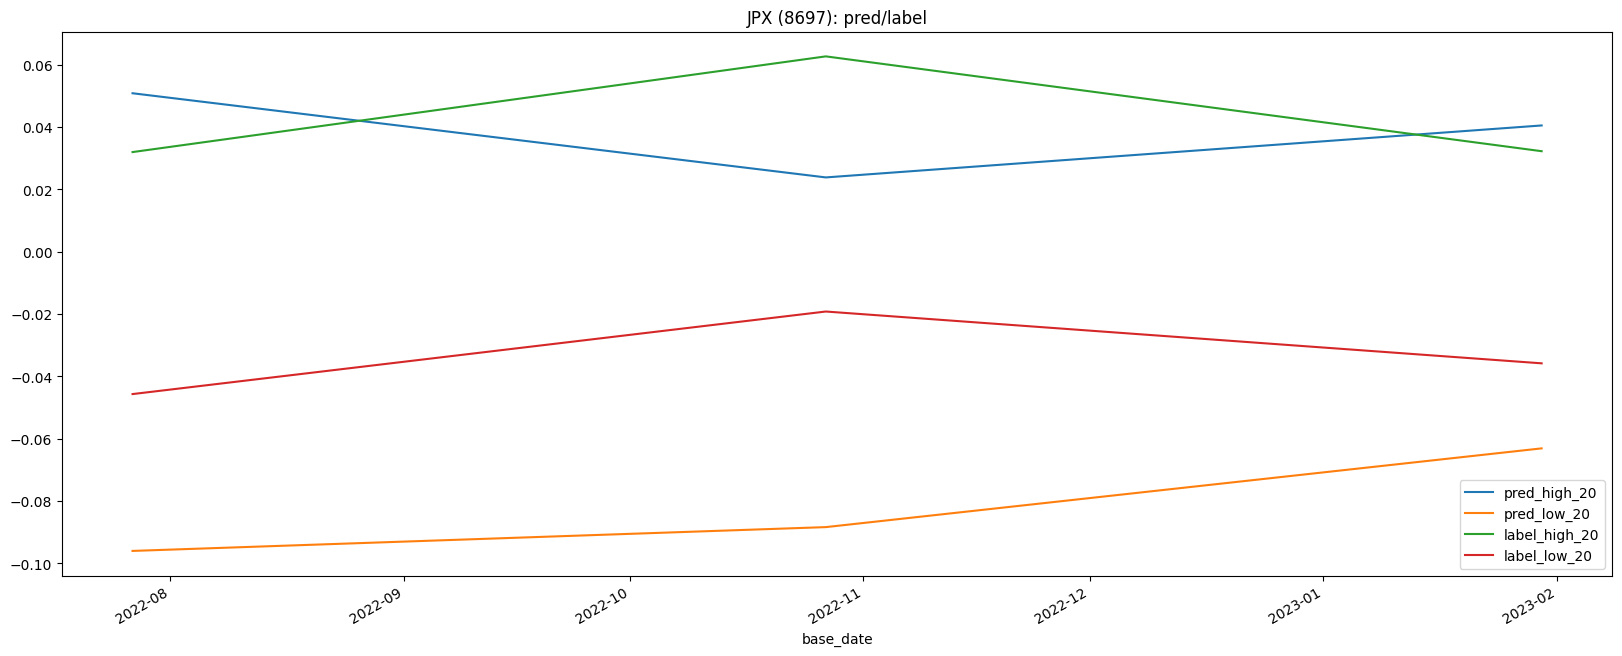

In [16]:
#@title JPX (8697) の予測とラベルを描画
df_m.loc[
    (df_m["Local Code"] == 8697) & (df_m["base_date"] >= test_start_dt),
    ["base_date", "pred_high_20", "pred_low_20", "label_high_20", "label_low_20"],
].set_index("base_date").plot(figsize=(20, 8), title="JPX (8697): pred/label")

  0%|          | 0/7 [00:00<?, ?it/s]

'latest_n: 10'

'label_high_20'

count    178.000000
mean       0.267983
std        0.347618
min       -0.733333
25%        0.018182
50%        0.333333
75%        0.527273
max        0.927273
dtype: float64

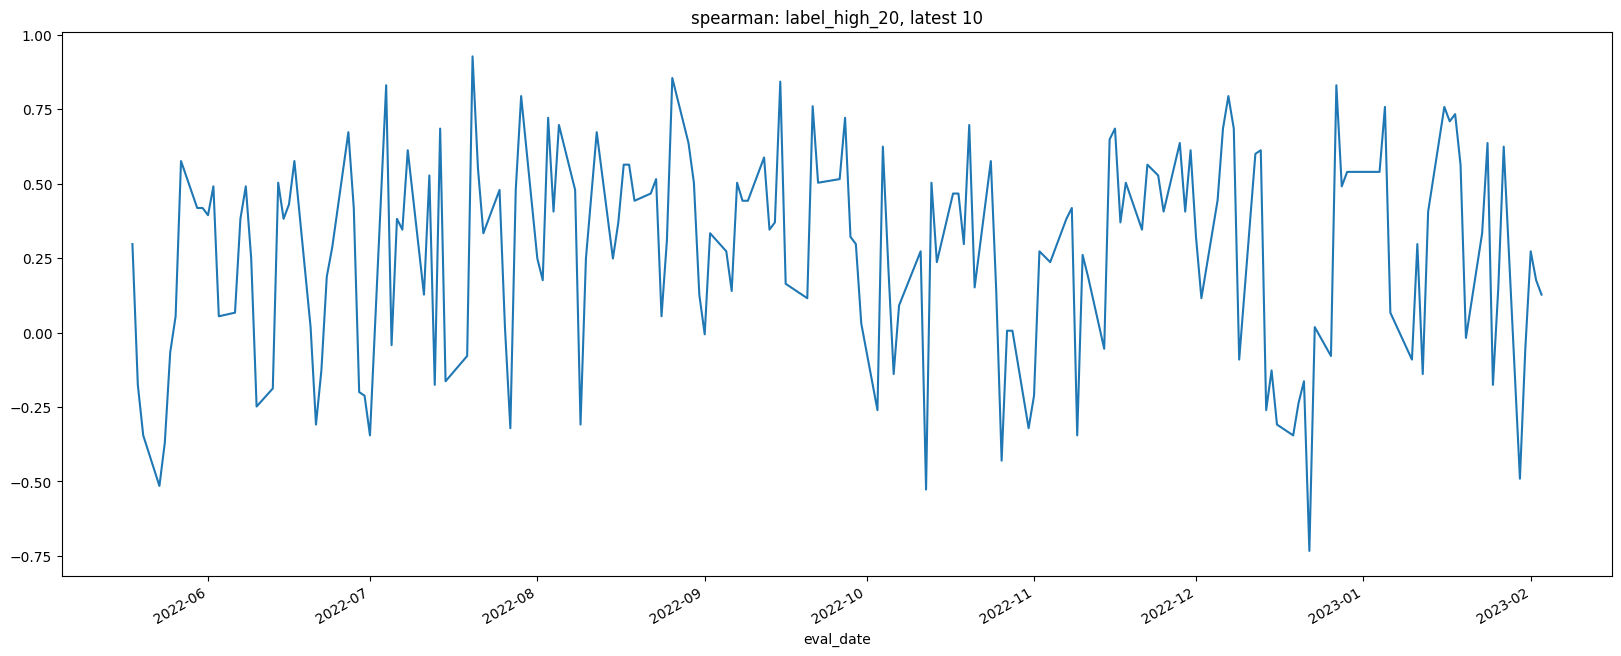

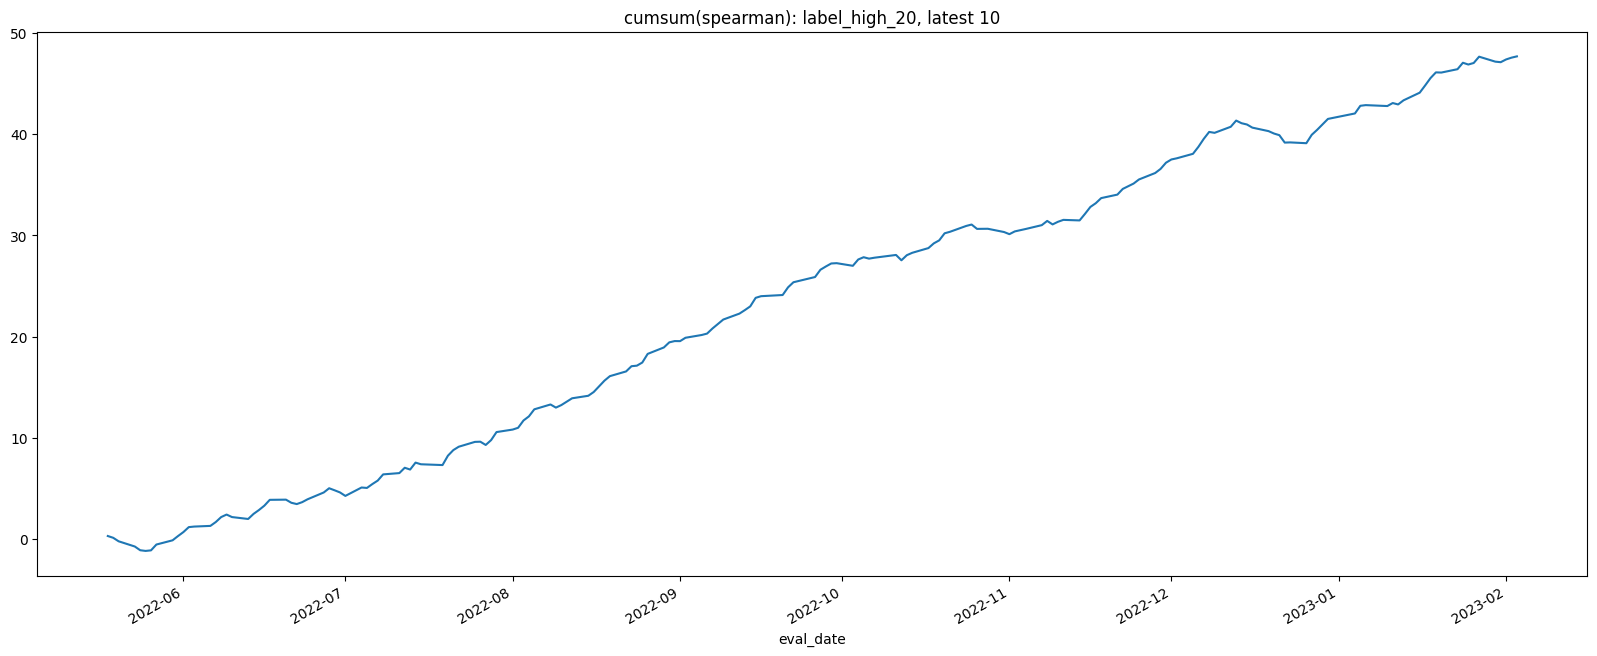

'latest_n: 20'

'label_high_20'

count    178.000000
mean       0.316236
std        0.223014
min       -0.347368
25%        0.182707
50%        0.310526
75%        0.492857
max        0.786466
dtype: float64

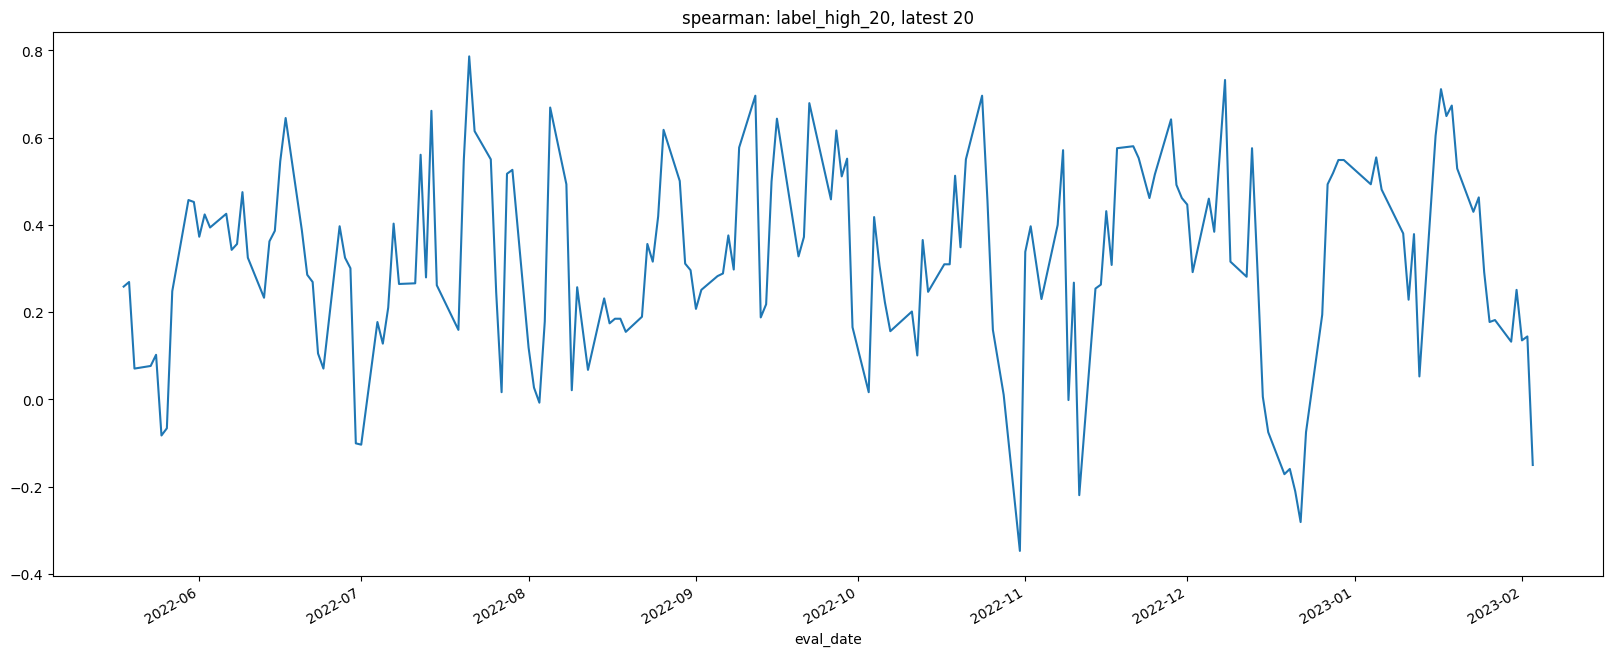

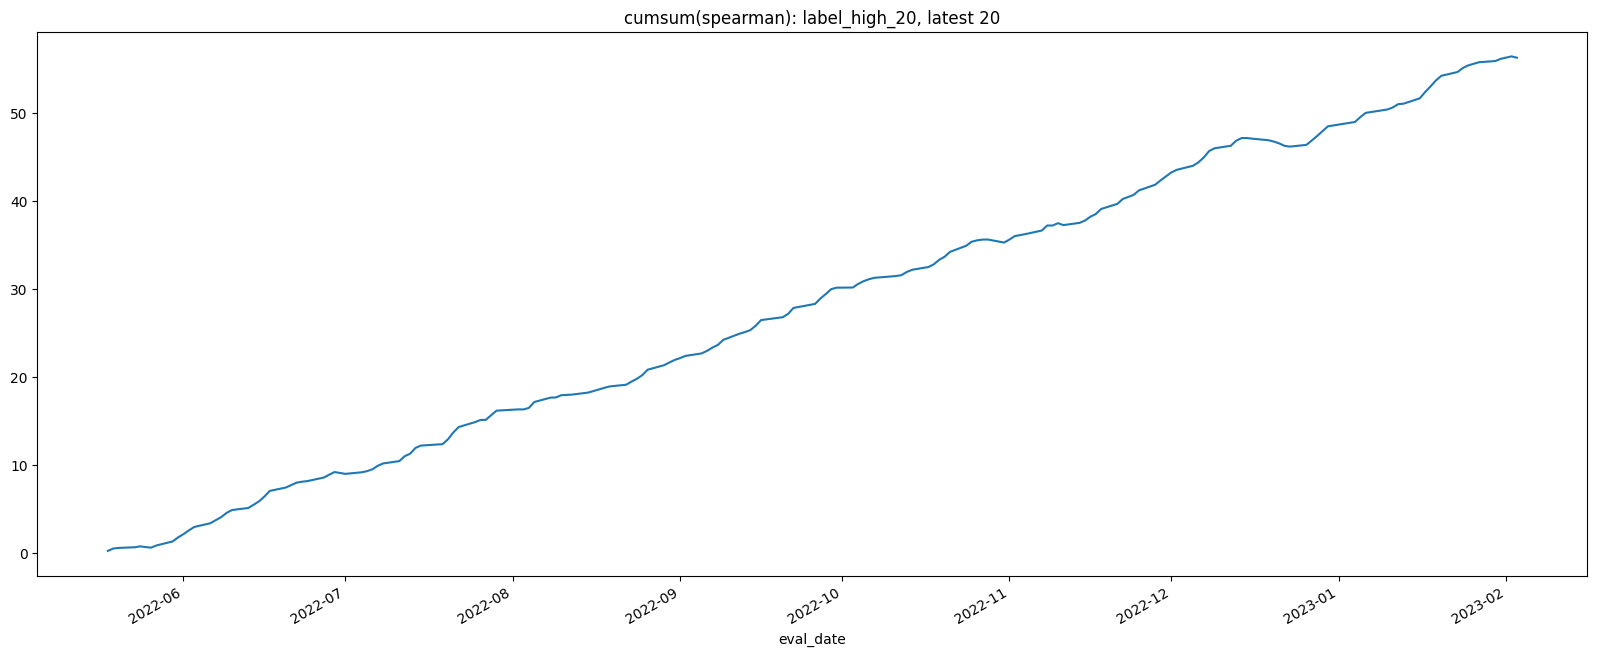

'latest_n: 50'

'label_high_20'

count    178.000000
mean       0.372826
std        0.142877
min       -0.029628
25%        0.279400
50%        0.377680
75%        0.478029
max        0.675390
dtype: float64

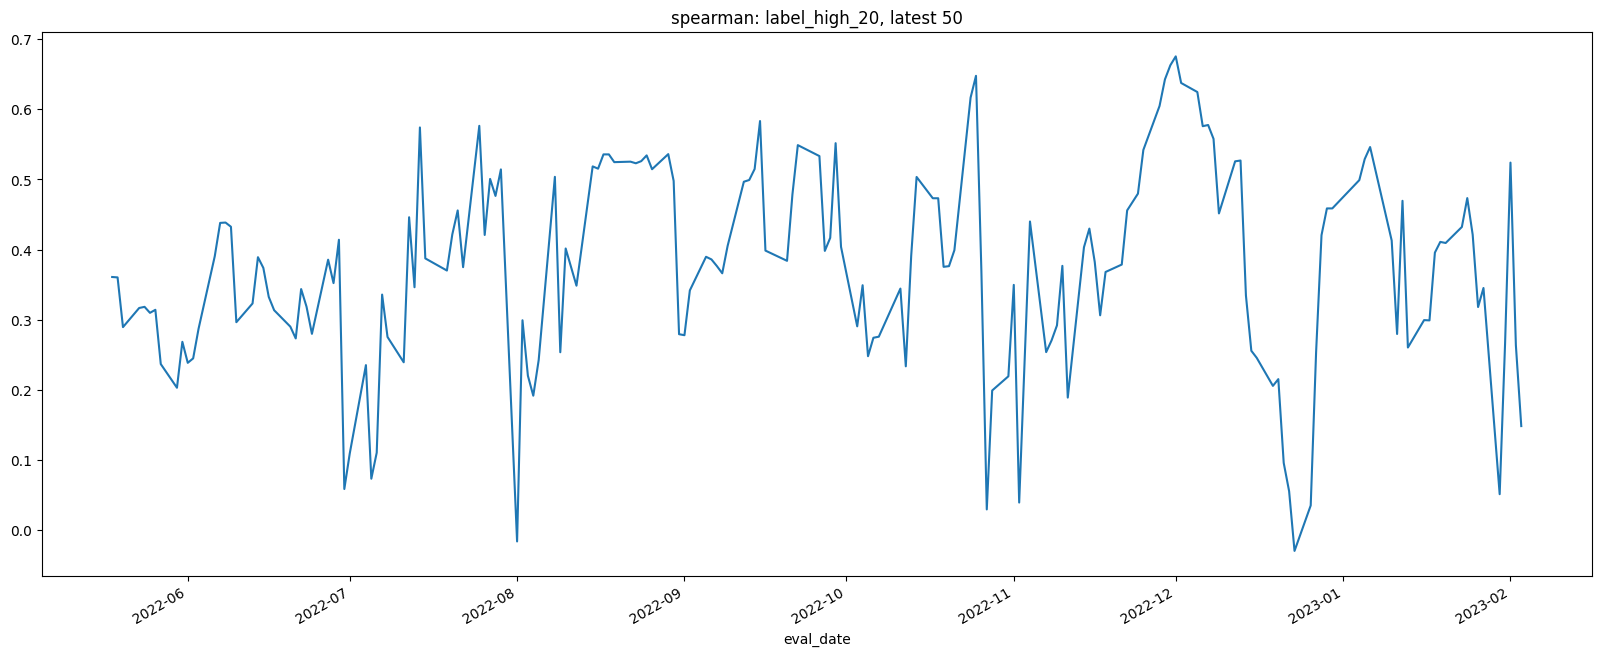

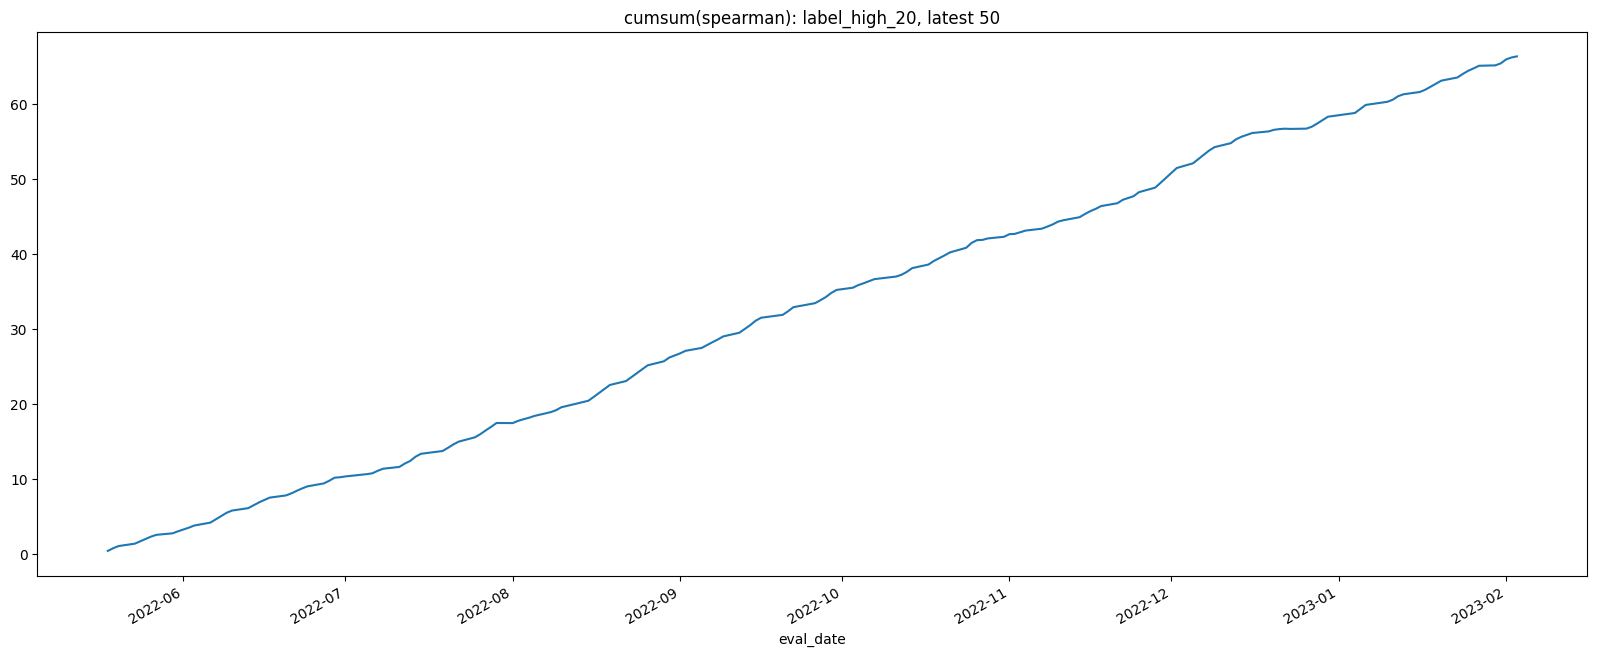

'latest_n: 100'

'label_high_20'

count    178.000000
mean       0.401113
std        0.102057
min        0.025023
25%        0.342349
50%        0.413379
75%        0.475519
max        0.617219
dtype: float64

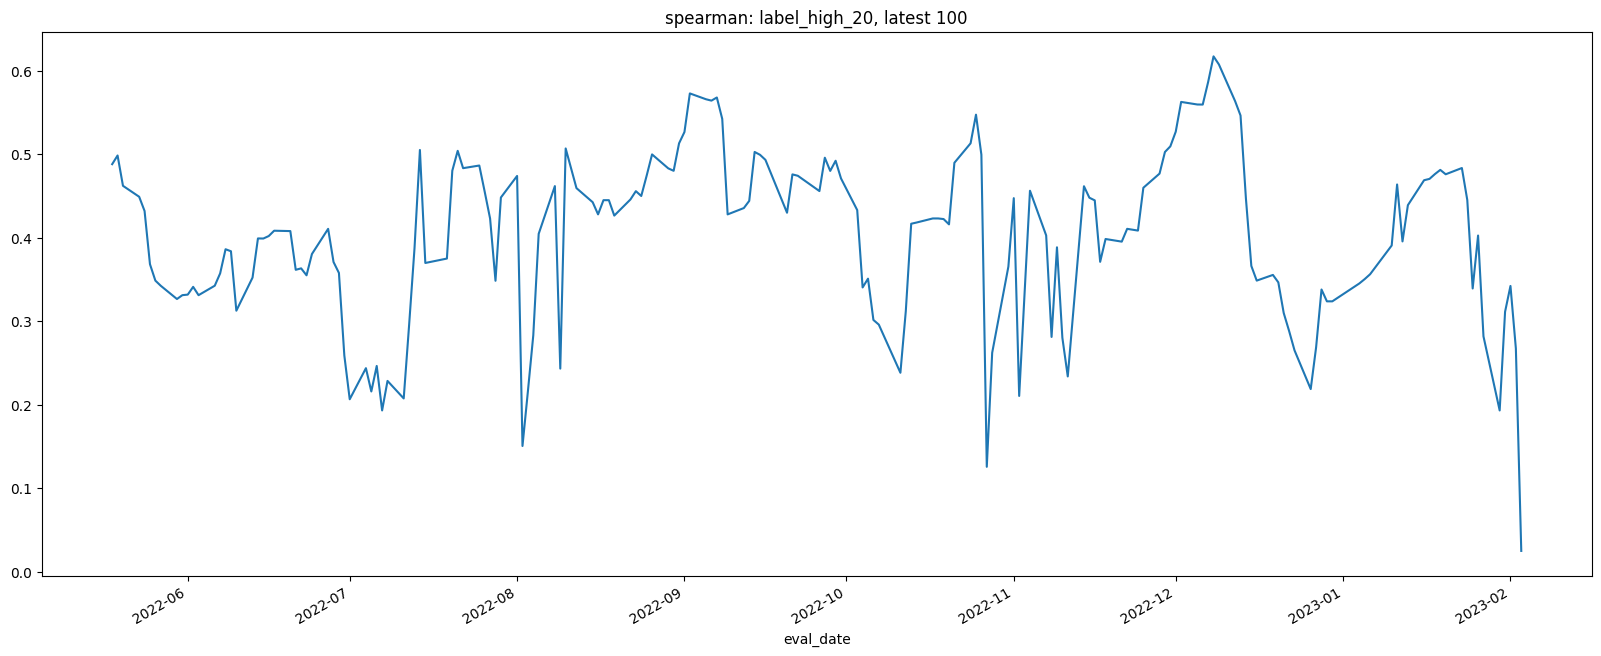

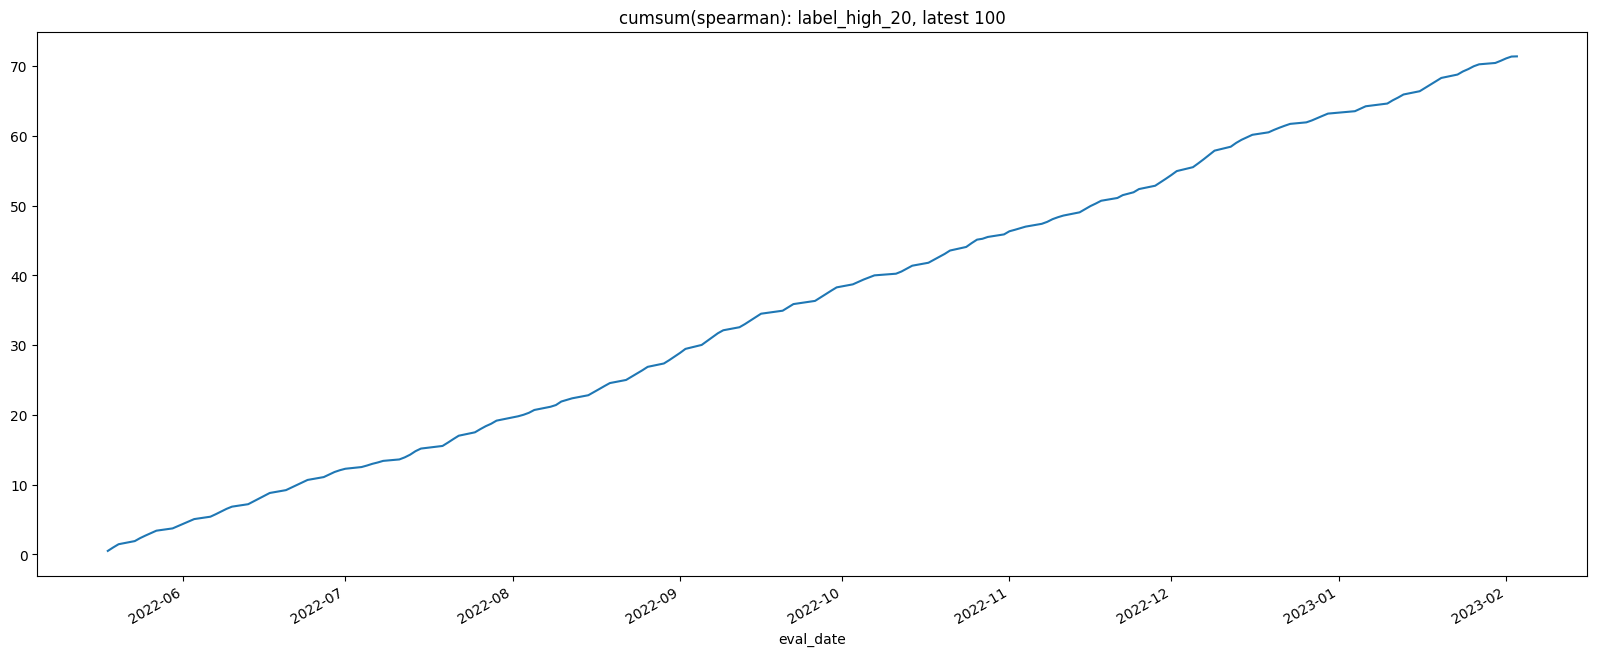

'latest_n: 200'

'label_high_20'

count    178.000000
mean       0.430419
std        0.085139
min        0.179823
25%        0.378401
50%        0.433676
75%        0.475653
max        0.623198
dtype: float64

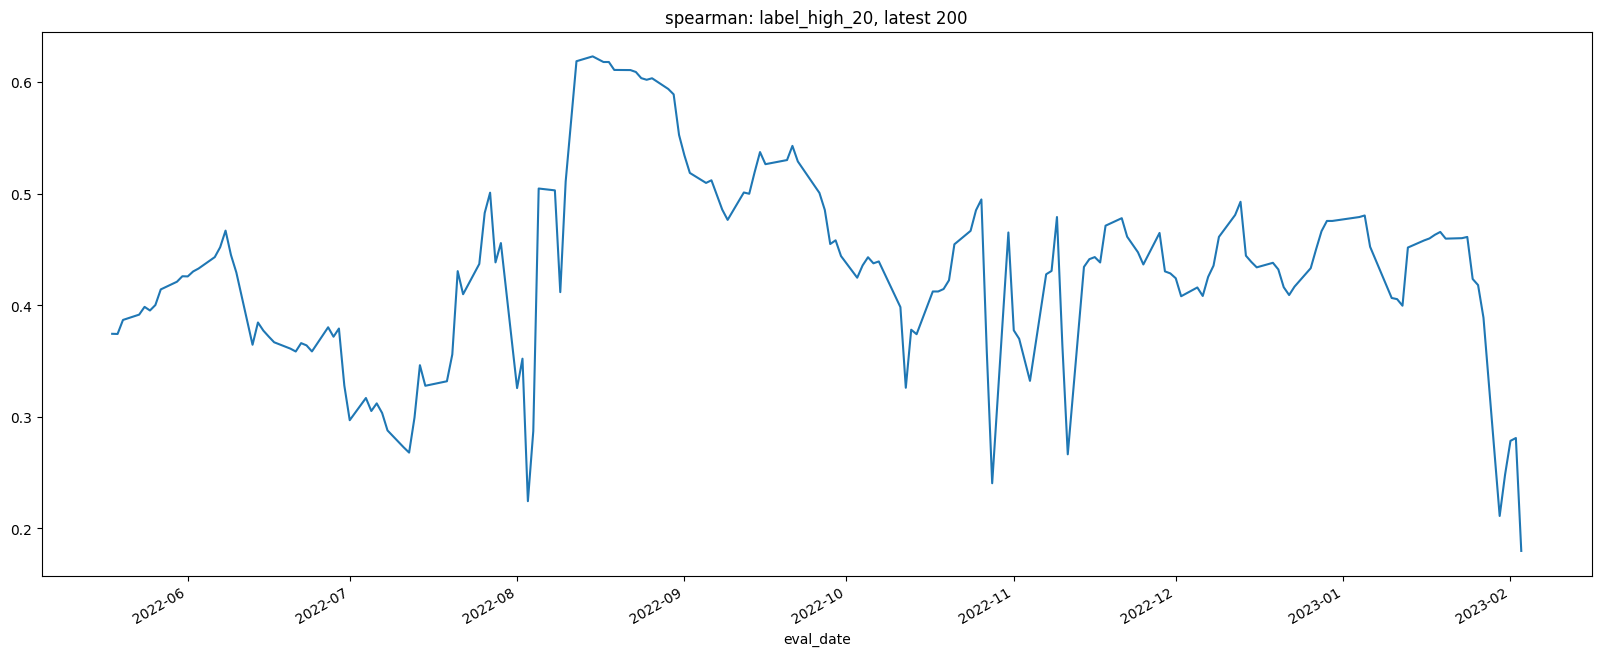

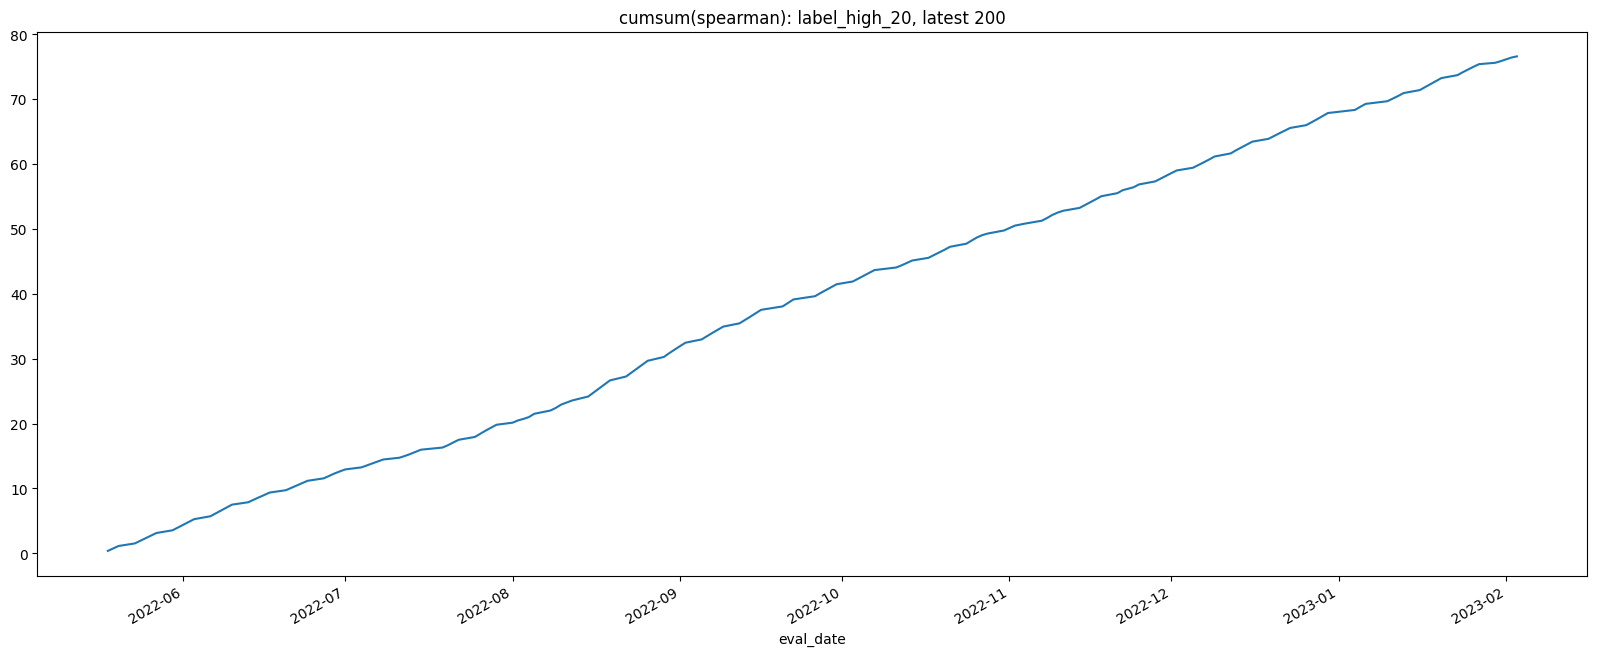

'latest_n: 300'

'label_high_20'

count    178.000000
mean       0.426658
std        0.075137
min        0.230231
25%        0.383676
50%        0.415398
75%        0.462651
max        0.590610
dtype: float64

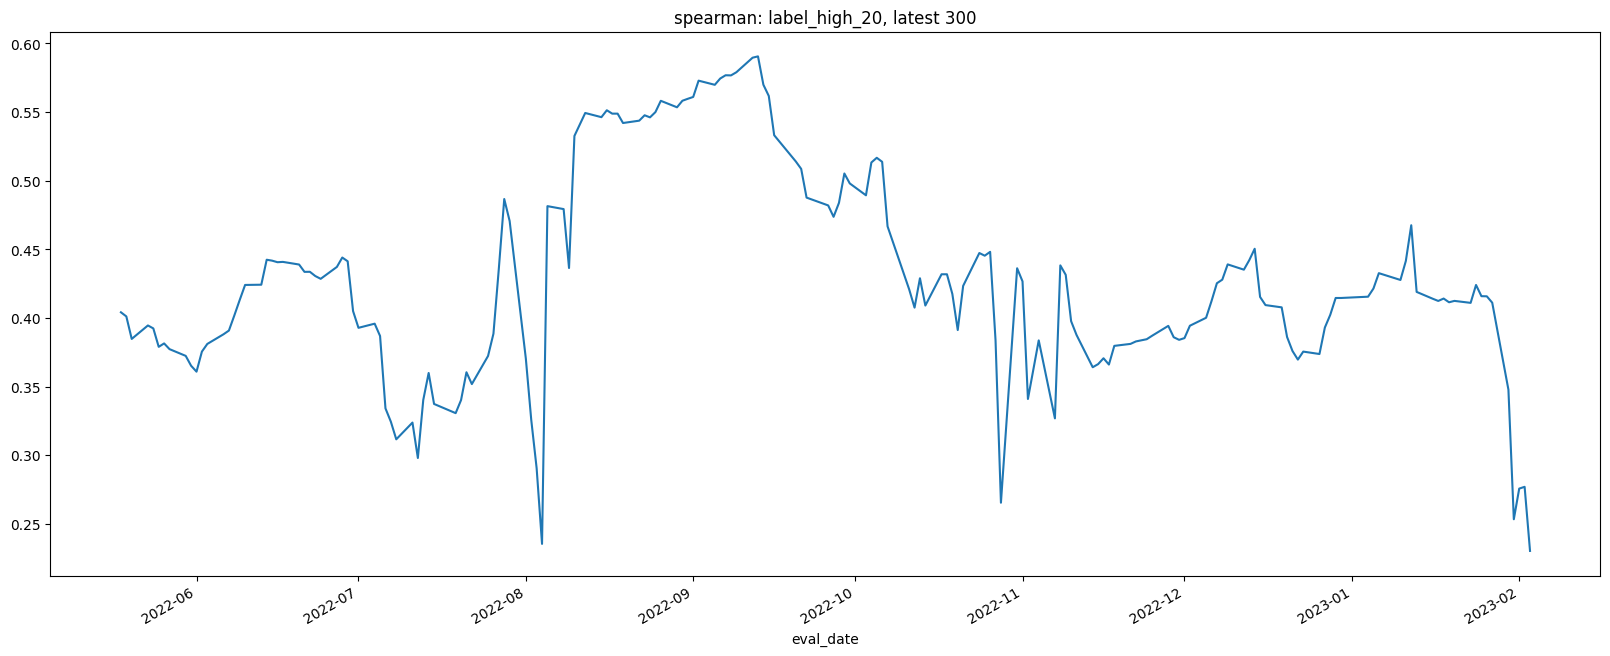

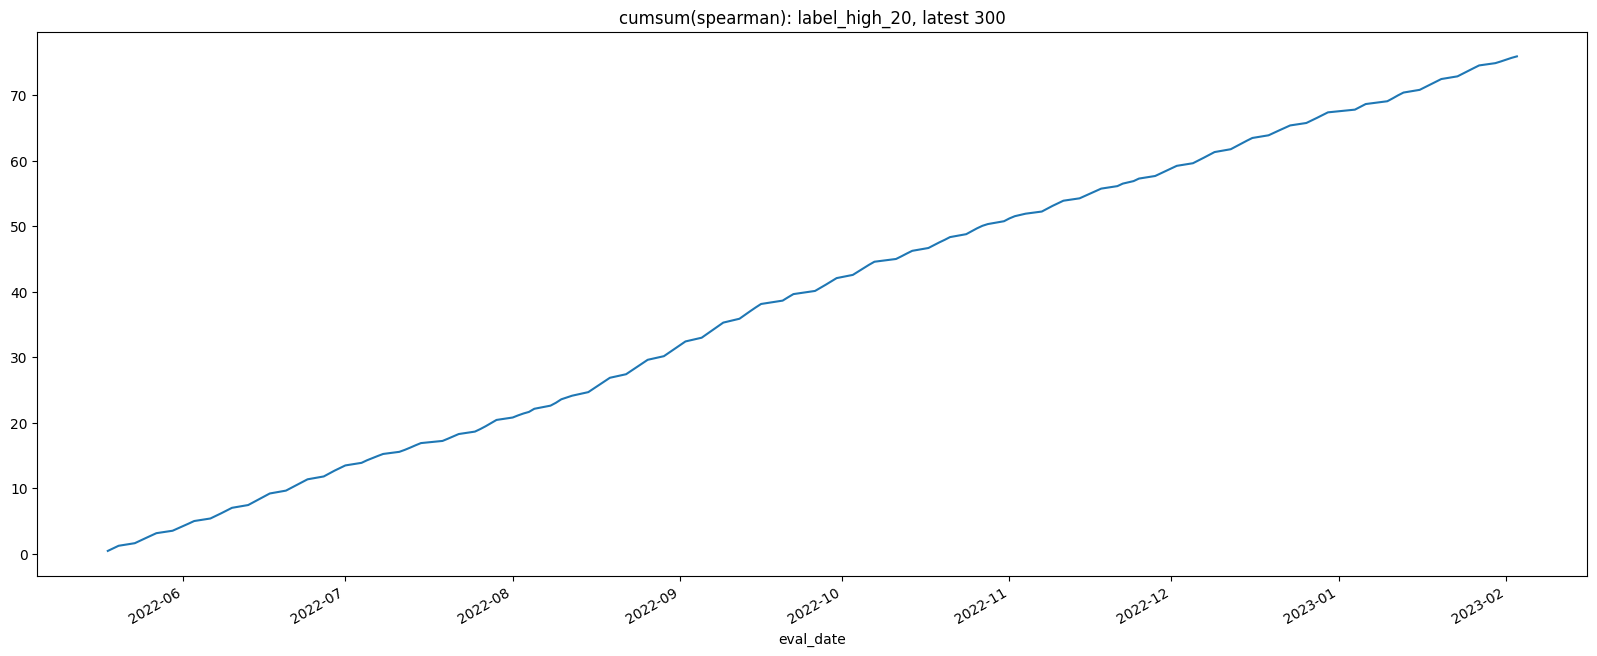

'latest_n: 400'

'label_high_20'

count    178.000000
mean       0.426816
std        0.073452
min        0.205684
25%        0.376551
50%        0.410279
75%        0.471666
max        0.575425
dtype: float64

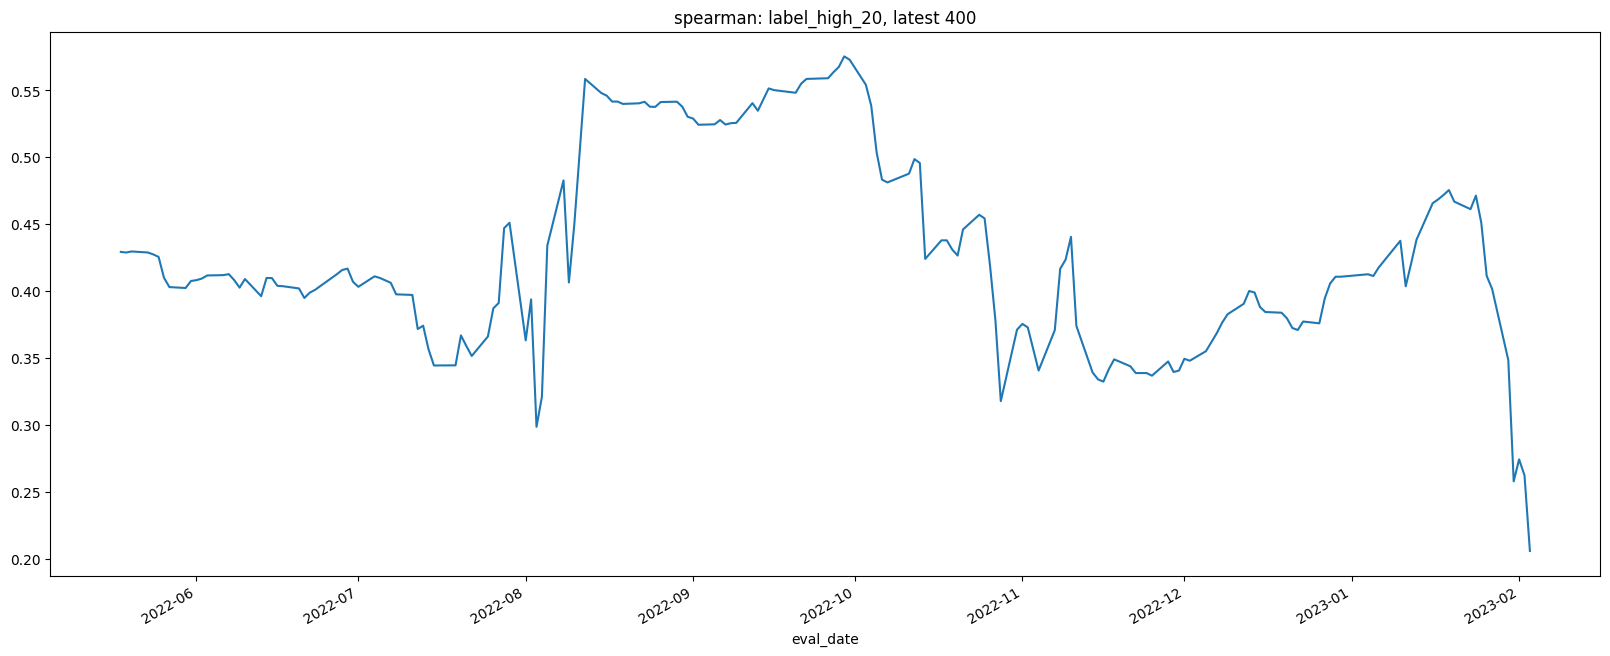

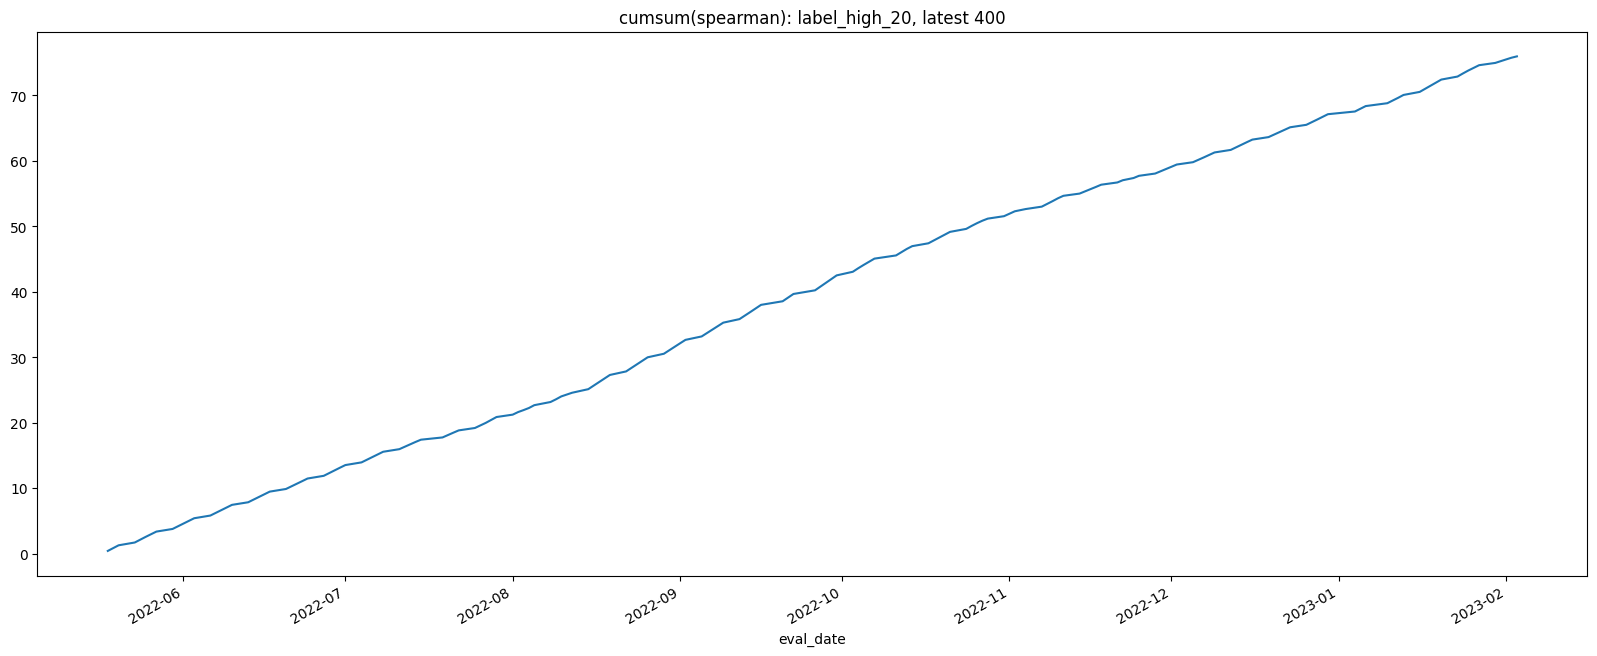

In [17]:
#@title 予測の評価(日次で直近n個の予測と正解ラベルとの順位相関を確認)

# ラベルの存在する営業日を取得します
dt_list = sorted(ppc.stock_labels.loc[ppc.stock_labels["label_high_20"].notna(), "base_date"].unique())

# 評価用に日次で直近n個の予測をグループ化します
df_m2 = df_m.sort_values(["base_date", "pred_high_20", "Local Code"])
# label が存在しないレコードを除外
df_m2 = df_m2.loc[df_m2["label_high_20"].notna()]
# グループ化
dfs_ret = {}
for latest_n in tqdm([10, 20, 50, 100, 200, 300, 400]):
    buff = []
    for dt in dt_list:
        tmp_df = df_m2.loc[df_m2["base_date"] <= dt].sort_values(["base_date", "pred_high_20", "Local Code"]).tail(latest_n).copy()
        tmp_df["eval_date"] = dt
        buff.append(tmp_df)
    df_ret = pd.concat(buff)
    df_ret.index = df_ret["eval_date"]
    df_ret.index.name = "date"

    # テスト期間に絞り込み
    df_ret = df_ret.loc[df_ret.index >= test_start_dt]
    dfs_ret[latest_n] = df_ret

from scipy.stats import spearmanr

def _spearmanr_high_20(df):
    return spearmanr(df["pred_high_20"].values, df["label_high_20"].values)[0]


# def _spearmanr_low_20(df):
#     return spearmanr(df["pred_low_20"].values, df["label_low_20"].values)[0]

for latest_n in [10, 20, 50, 100, 200, 300, 400]:
    display(f"latest_n: {latest_n}")
    # display(dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr).head(2))
    # display(dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr).tail(2))
    display("label_high_20")
    display(dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_high_20).describe())
    dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_high_20).plot(figsize=(20, 8), title=f"spearman: label_high_20, latest {latest_n}")
    plt.show()
    dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_high_20).cumsum().plot(figsize=(20, 8), title=f"cumsum(spearman): label_high_20, latest {latest_n}")
    plt.show()
    # display("label_low_20")  # low側を評価するにはグループ化方法もlowに合わせたもので実施するのがよいです
    # display(dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_low_20).describe())
    # dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_low_20).plot(figsize=(20, 8), title=f"spearman: label_low_20, latest {latest_n}")
    # plt.show()
    # dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_low_20).cumsum().plot(figsize=(20, 8), title=f"cumsum(spearman): label_low_20, latest {latest_n}")
    # plt.show()

## ポートフォリオ
- クラス構成 : FeatureLoader > PortfolioModelBuilder > PortfolioManager

In [18]:
#@title ポートフォリオモデル
"""
特徴量読み込み
"""
class FeatureLoader:
    def __init__(self, end_dt, purchase_dt):
        self.stock_list = None
        self.stock_fins = None
        self.stock_price = None
        self.stock_labels = None
        self.feature = None
        self.target_codes = None
        self.models = None

        # リークを防ぐため､各期間に間隔（1か月）を空けている
        self.TRAIN_END = (end_dt- relativedelta(months=10) - relativedelta(months=2)).strftime("%Y-%m-%d") 
        self.VAL_START = (end_dt- relativedelta(months=10) - relativedelta(months=1)).strftime("%Y-%m-%d") # 5月分
        self.VAL_END =  (end_dt- relativedelta(months=5) - relativedelta(months=1)).strftime("%Y-%m-%d")
        self.TEST_START = (end_dt- relativedelta(months=5)).strftime("%Y-%m-%d") # 5月分
        self.purchase_dt = purchase_dt

        self.labels = ["label_high_20", "label_low_20"]

    """
    データ読み込み
    """
    def get_dataset(self)->list:
        # データ取得
        self.stock_list = pd.read_csv(stock_list_csvfile_path)
        self.stock_fins = pd.read_csv(stock_fins_csvfile_path)
        self.stock_price = pd.read_csv(stock_price_csvfile_path)
        self.stock_labels = pd.read_csv(stock_labels_csvfile_path)
        self.feature = pd.read_csv(feature_path)

        self.stock_price.loc[:, "datetime"] = self.stock_price.loc[:, "base_date"]
        self.stock_price.set_index("datetime", inplace=True)
        self.stock_fins.loc[:, "datetime"] = self.stock_fins.loc[:, "base_date"]
        self.stock_fins.set_index("datetime", inplace=True)
        self.stock_labels.loc[:, "datetime"] = self.stock_labels.loc[:, "base_date"]
        self.stock_labels.set_index("datetime", inplace=True)
        self.feature = self.feature[self.feature.columns[~self.feature.columns.str.contains('Unnamed')]]
        self.feature["base_date"] = pd.to_datetime(self.feature["base_date"])

        # 予測対象銘柄
        self.target_codes = self.stock_list[self.stock_list["universe_comp2"] == True]["Local Code"].values

    """
    特徴量の選択
    """
    def get_feature_columns(self, column_group="fundamental+technical"):
        # 特徴量グループを定義
        # ファンダメンタル
        fundamental_cols = self.stock_fins.select_dtypes("float64").columns
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]

        # 価格変化率
        returns_cols = [x for x in self.feature.columns if "return" in x]

        # テクニカル
        technical_cols = [x for x in self.feature.columns if (x not in fundamental_cols) and (x != "code")]

        columns = {
            "fundamental_only": fundamental_cols,
            "return_only": returns_cols,
            "technical_only": technical_cols,
            "fundamental+technical": list(fundamental_cols) + list(technical_cols),
        }
        return columns[column_group]

"""
ポートフォリオモデル構築
"""
class PortfolioModelBuilder(FeatureLoader):
    def __init__(self, end_dt, purchase_dt):
         super().__init__(end_dt, purchase_dt)

    """
    モデル取得
    """
    def get_model(self, model_path=model_path):
        if self.models is None:
            self.models = {}
        for label in self.labels:
            m = os.path.join(model_path, f"my_model_{label}.pkl")
            with open(m, "rb") as f:
                # pickle形式で保存されているモデルを読み込み
                self.models[label] = pickle.load(f)
        return True

    """
    ポートフォリオの組成
    """
    def predict(self, fin_columns=None, strategy_id=1):
        # 予測対象日を調整(start_dtにはポートフォリオの購入日を指定しているため、予測に使用する前週の金曜日を指定します。)
        self.purchase_dt = pd.Timestamp(self.purchase_dt) - pd.Timedelta("3D")

        # 特徴量のindexの設定
        self.feature.loc[:, "datetime"] = self.feature.loc[:, "base_date"]
        self.feature.set_index("datetime", inplace=True)

        # 日付と銘柄コードに絞り込み
        df = self.feature.loc[:, ["Local Code"]].copy()

        # 購入金額を設定
        df.loc[:, "budget"] = 50000
        
        # 予測
        x_feature = [f for f in self.feature.columns if f not in ["base_date", "Local Code", "label_high_20", "label_low_20"]]
        y_labels = ["label_high_20", "label_low_20"]

        # 特徴量カラムを指定
        feature_columns = self.get_feature_columns()

        # feature_cols = feature.columns
        # feature_cols = feature_cols[feature_cols != "code"]

        for label in tqdm(self.labels):
            df[label] = self.models[label].predict(self.feature[x_feature])



        # 銘柄選択方法選択
        df =  PortfolioModelBuilder.strategy(strategy_id, df)

        # 日付順に並び替え
        df.sort_index(kind="mergesort", inplace=True)
        # 月曜日日付に変更
        df.index = df.index + pd.Timedelta("3D")
        # 出力用に調整
        df.index.name = "date"
        # df.rename(columns={"code": "Local Code"}, inplace=True)
        df.reset_index(inplace=True)

        # 出力対象列を定義
        output_columns = ["date", "Local Code", "budget"]

        out = io.StringIO()
        df.to_csv(out, header=True, index=False, columns=output_columns)

        # ポートフォリオを保存
        with open(f"backtest-{strategy_id}.csv", mode="w") as f:
            f.write(out.getvalue())
        print(f"saved <backtest-{strategy_id}.csv>")
        
        return out.getvalue()

    # 戦略
    @staticmethod
    def strategy(strategy_id, df):
        df = df.copy()

        # 銘柄選択方法選択
        if strategy_id in [1, 4]:
            # 最高値モデル +　最安値モデル
            df.loc[:, "pred"] = df.loc[:, "label_high_20"] + df.loc[:, "label_low_20"]
        elif strategy_id in [2, 5]:
            # 最高値モデル
            df.loc[:, "pred"] = df.loc[:, "label_high_20"]
        elif strategy_id in [3, 6]:
            # 最高値モデル
            df.loc[:, "pred"] = df.loc[:, "label_low_20"]
        else:
            raise ValueError("no strategy_id selected")

        # 予測出力を降順に並び替え
        df = df.sort_values("pred", ascending=False)
        # 予測出力の大きいものを取得
        df = df.groupby("datetime").head(5)

        return df

class PortfolioManager(PortfolioModelBuilder):
    def __init__(self, end_dt:datetime, purchase_dt:datetime):
         super().__init__(end_dt, purchase_dt)

    def executer(self, strategy_id:int=1):
        # self.create_model()
        print("[+] load data")
        self.get_dataset()
        print("[+] load model")
        self.get_model()
        # print("[+] predict")
        # self.predict(strategy_id)

In [19]:
#@title バックテストモデル
"""
株式分析チュートリアルのbacktest.pを参照
https://github.com/JapanExchangeGroup/J-Quants-Tutorial/blob/main/handson/Chapter03/backtest/backtest.py
"""
import numpy as np
import pandas as pd
from tqdm.auto import tqdm


# バックテスト実行用クラス
class Backtest(object):
    # バックテストパラメータ
    # 対象列定義
    DATE = "date"
    CODE = "Local Code"
    BUDGET = "budget"
    # 日付フォーマット定義
    DATE_FORMAT = "%Y-%m-%d"
    # 購入順列 (読み込み時にレコード順を付与する)
    BUYING_ORDER = "n"
    # 最低銘柄選択数。これより少ない場合はエラーとする
    MIN_STOCKS = 0
    # 最低購入金額。購入額がこの金額より少ない場合は、超えるまでリスト内の銘柄を購入する
    BOUGHT_MIN = 500000
    # 予算。この金額以上は購入しない
    BOUGHT_MAX = 1000000

    # 入力データ準備
    @classmethod
    def prepare_data(cls, data_dir: str):
        # バックテストへの入力用データを作成します

        UNIVERSE_COL = "universe_comp2"
        CODE_COL = "Local Code"

        # ユニバース取得
        # 銘柄情報読み込み
        df_stock_list = pd.read_csv(f"{data_dir}/stock_list.csv.gz")
        # 問題2のユニバース取得
        codes = df_stock_list.loc[
            df_stock_list.loc[:, UNIVERSE_COL] == True, CODE_COL
        ].values

        # 価格情報読み込み
        df_price = pd.read_csv(f"{data_dir}/stock_price.csv.gz")
        # インデックス設定
        df_price.set_index("EndOfDayQuote Date", inplace=True)
        # インデックスを日付型に変更
        df_price.index = pd.to_datetime(df_price.index)
        # ユニバースに絞り込む
        df_price = df_price.loc[df_price.loc[:, CODE_COL].isin(codes)]

        return codes, df_price

    # 提出用データ読み込み
    @classmethod
    def load_submit(cls, file_path: str) -> pd.DataFrame:
        # データ読み込み
        df = pd.read_csv(file_path)

        # カラム存在検証
        if cls.DATE not in df.columns:
            raise ValueError(f"{cls.DATE} is missing in columns: {df.columns}")
        if cls.CODE not in df.columns:
            raise ValueError(f"{cls.CODE} is missing in columns: {df.columns}")
        if cls.BUDGET not in df.columns:
            raise ValueError(f"{cls.BUDGET} is missing in columns: {df.columns}")

        # インデックス設定
        df.set_index(cls.DATE, inplace=True)
        df.index = pd.to_datetime(df.index, format=cls.DATE_FORMAT)

        # データ型を設定
        df.loc[:, cls.CODE] = df.loc[:, cls.CODE].astype(np.int64)
        df.loc[:, cls.BUDGET] = df.loc[:, cls.BUDGET].astype(np.int64)

        # レコード順を保存
        df.loc[:, cls.BUYING_ORDER] = np.arange(df.shape[0])

        return df.loc[:, [cls.CODE, cls.BUDGET, cls.BUYING_ORDER]]

    # バックテスト実行関数
    @classmethod
    def calc_trades(cls, df_t, df_price):
        """
        入力:
            df_t (DataFrame): １週間分のポートフォリオ
            df_price (DataFrame): 株価情報
        出力:
            d_sum (dict[str, float]): 購入総額及びリターンの基準となる評価額
            buff_holiday  (list[int]): 祝日などで株価の存在しなかった曜日 (0: 月曜日、5: 金曜日)
            df_t (DataFrame): 銘柄の売り買い履歴
        """
        # 購入順に並び替え
        df_t = df_t.sort_values(cls.BUYING_ORDER)

        # 対象日付を取得
        s = df_t.index[0]

        # 予測対象の銘柄コードのみに絞り込み
        df_t = df_t.loc[df_t.loc[:, cls.CODE].isin(df_price.loc[:, cls.CODE].unique())]

        # 月曜日以外の場合はエラー
        if s.dayofweek != 0:
            raise ValueError(f"date:{s} is not Monday")

        # indexをユニーク値に変更
        df_t = df_t.reset_index()

        # 銘柄コードを取得
        stock_codes = df_t.loc[:, cls.CODE].unique()

        # 5銘柄以上選択されているかを確認
        if len(stock_codes) < cls.MIN_STOCKS:
            # 4銘柄以下の場合エラー
            raise ValueError(f"num of stocks should be more than or equal to 5. {df_t}")

        #  株価情報を対象日付で絞り込む
        df_price = df_price.sort_index().loc[s : s + pd.Timedelta("4D")]
        # 銘柄コードと日付で絞り込んだ株価を用意しておく
        dfp = {}
        # 銘柄コード毎に処理
        for stock_code in stock_codes:
            # 曜日ごとに処理
            for t in range(5):
                # 各曜日の日付を取得
                t_index = s + pd.Timedelta(f"{t}D")
                # 各銘柄、各曜日ごとの価格情報を保存
                dfp[(stock_code, t_index)] = df_price.loc[
                    (df_price.index == t_index)
                    & (df_price.loc[:, cls.CODE] == stock_code)
                ]

        # カラムを追加
        for col in ["entry", "day_1", "day_2", "day_3", "day_4", "day_5", "bought"]:
            df_t.loc[:, col] = 0.0
        df_t.loc[:, "actual"] = 0

        # 購入金額および日々の評価額保存用
        d_sum = {
            "bought_sum": 0,
            "day_1": 0,
            "day_2": 0,
            "day_3": 0,
            "day_4": 0,
            "day_5": 0,
        }

        # 祝日保存用
        buff_holiday = []
        # 購入ステータスフラグ
        buying = True
        salvation = False

        # メインループ: 銘柄を購入して日次の評価額を計算する
        # 1日毎に処理
        for offset in range(5):
            # 対象日付を取得
            t_index = s + pd.Timedelta(f"{offset}D")
            ##########
            # 祝日判定
            ##########
            if df_price.loc[(df_price.index == t_index)].shape[0] == 0:
                # 前日の評価額を引き継ぎ
                if offset == 0:
                    # 現金をそのままスライド
                    d_sum[f"day_{offset + 1}"] = cls.BOUGHT_MAX
                else:
                    d_sum[f"day_{offset + 1}"] = d_sum[f"day_{offset}"]
                # 祝日を保存
                buff_holiday.append(offset)
                continue
            ##########
            # 最初の営業日
            ##########
            if buying:
                # 購入フラグを設定
                buying = False
                # 処理回数カウント用
                iter_count = 0
                # 最低購入額を満たすまで実行
                while df_t["bought"].sum() < cls.BOUGHT_MIN:
                    # 処理回数を記録
                    iter_count += 1
                    # 処理回数が5万回を超える場合はエラーとする
                    if iter_count > 50000:
                        raise ValueError(f"[FILL] cannot not buy stocks: {df_t} ")

                    # レコード毎に処理
                    for i in df_t.index:
                        # 対象の銘柄コード
                        stock_code = df_t.loc[i, cls.CODE]
                        # 価格情報
                        df_p = dfp[(stock_code, t_index)]
                        # 価格情報がなかった場合 (上場前や廃止が考えられる)
                        if df_p.shape[0] == 0:
                            continue
                        # 値段がついていない場合★
                        if np.isnan(df_p.iloc[0]["EndOfDayQuote Open"]):
                            # 終値
                            df_t.loc[i, f"day_{offset + 1}"] = df_p.iloc[0][
                                "EndOfDayQuote ExchangeOfficialClose"
                            ]
                            continue
                        if salvation:
                            # 購入数量指定 (1固定)
                            buying_qty = 1
                        else:
                            # 予算を取得
                            buying_budget = min(
                                # レコードの予算額
                                df_t.loc[i, cls.BUDGET],
                                # 全体の予算額
                                cls.BOUGHT_MAX - df_t["bought"].sum(),
                            )
                            # 指定された金額での購入数量算出
                            buying_qty = int(
                                buying_budget
                                // (
                                    df_p.iloc[0]["EndOfDayQuote Open"]
                                    * df_p.iloc[0][
                                        "EndOfDayQuote CumulativeAdjustmentFactor"
                                    ]
                                )
                            )
                        # 累積調整係数を使用して購入数量を調整後数量に変更する
                        buying_qty *= df_p.iloc[0][
                            "EndOfDayQuote CumulativeAdjustmentFactor"
                        ]
                        # 購入金額算出
                        buying_amount = df_p.iloc[0]["EndOfDayQuote Open"] * buying_qty
                        # 終値基準価格算出
                        close_amount = (
                            df_p.iloc[0]["EndOfDayQuote ExchangeOfficialClose"]
                            * buying_qty
                        )
                        # 購入した場合に合計予算を超えないことを確認
                        tmp_bought_sum = df_t["bought"].sum() + buying_amount
                        if tmp_bought_sum > cls.BOUGHT_MAX:
                            # 予算を超える場合は購入しない
                            continue
                        # 購入額
                        d_sum["bought_sum"] += buying_amount
                        # # 購入額
                        # d_sum[f"day_{offset + 1}_open"] += buying_amount
                        # # 終値
                        d_sum[f"day_{offset + 1}"] += close_amount
                        df_t.loc[i, "bought"] += buying_amount
                        # 購入履歴
                        df_t.loc[i, "actual"] += buying_qty
                        # 購入価格
                        df_t.loc[i, "entry"] = df_p.iloc[0]["EndOfDayQuote Open"]
                        # 終値
                        df_t.loc[i, f"day_{offset + 1}"] = df_p.iloc[0][
                            "EndOfDayQuote ExchangeOfficialClose"
                        ]

                        # 購入金額が閾値以上となったら購入停止
                        if salvation and df_t["bought"].sum() >= cls.BOUGHT_MIN:
                            break
                    # 1株ずつ購入するように設定
                    salvation = True

                # 購入銘柄数が5未満の場合はエラーにする
                if (
                    len(df_t.loc[df_t.loc[:, "actual"] > 0, "Local Code"].unique())
                    < cls.MIN_STOCKS
                ):
                    raise ValueError(
                        f"Number of bought stocks is less than 5: {t_index}"
                    )
                # 最初の営業日の資産計上
                d_sum[f"day_{offset + 1}"] += cls.BOUGHT_MAX - d_sum["bought_sum"]
                # 最初の営業日終了
                continue

            # 2日目から5日目
            # for stock_code in buff_trans.keys():
            for i in df_t.index:
                stock_code = df_t.loc[i, cls.CODE]
                df_p = dfp[(stock_code, t_index)]
                if df_p.shape[0] == 0:
                    # レコードが見つからない場合は上場廃止が考えられる
                    # 救済措置としてExchangeOfficialCloseをffillして対応する
                    print(f"DELISTED: code: {stock_code}, no data: {t_index}")
                    # 終値ベースでの保有額
                    d_sum[f"day_{offset + 1}"] += (
                        df_t.loc[i, f"day_{offset}"] * df_t.loc[i, "actual"]
                    )
                    # 終値
                    df_t.loc[i, f"day_{offset + 1}"] = df_t.loc[i, f"day_{offset}"]
                    continue
                # 終値ベースでの保有額
                d_sum[f"day_{offset + 1}"] += (
                    df_p.iloc[0]["EndOfDayQuote ExchangeOfficialClose"]
                    * df_t.loc[i, "actual"]
                )
                # 終値
                df_t.loc[i, f"day_{offset + 1}"] = df_p.iloc[0][
                    "EndOfDayQuote ExchangeOfficialClose"
                ]
            # 営業日の資産計上
            d_sum[f"day_{offset + 1}"] += cls.BOUGHT_MAX - d_sum["bought_sum"]

        # 購入銘柄数が閾値未満の場合はエラー
        if (len(buff_holiday) != 5) and (
            len(df_t.loc[df_t.loc[:, "actual"] > 0, "Local Code"].unique())
            < cls.MIN_STOCKS
        ):
            raise ValueError(f"bought_count is less than {cls.MIN_STOCKS}")

        # 購入金額がしきい値未満の場合はエラー
        bought_sum = df_t["bought"].sum()
        if (len(buff_holiday) != 5) and (bought_sum < cls.BOUGHT_MIN):
            raise ValueError(f"bought_sum:{bought_sum} is less than {cls.BOUGHT_MIN}")

        return (
            d_sum,
            buff_holiday,
            df_t,
        )

    @classmethod
    def run(cls, df_submit, stock_codes, df_price):
        """
        入力:
            df_submit (DataFrame): ポートフォリオ
            stock_codes (list): ユニバース
            df_price (DataFrame): 株価情報
        出力:
            df_return (DataFrame): ポートフォリオのリターン
            df_transaction (DataFrame): 銘柄の売り買い履歴
        """
        MONDAY = 0

        buff_return = []
        buff_stocks = []

        # Nanが含まれていないことを確認
        if df_submit.isnull().values.any():
            raise ValueError("This DataFrame includes Nan values")

        # 入力データ確認
        # 1:買い注文の銘柄が予測対象かをチェック
        # 予測対象銘柄のみに絞り込む
        df_submit = df_submit.loc[df_submit.loc[:, cls.CODE].isin(stock_codes)]

        # 2:月曜日の日付のみを評価対象とする
        # 月曜日の日付のみに絞り込む
        df_submit = df_submit.loc[df_submit.index.dayofweek == MONDAY]

        # 購入金額が1未満のレコードを除外する
        df_submit = df_submit.loc[df_submit.loc[:, cls.BUDGET] >= 1]

        # 提出データを１週間毎にリターンを計算する
        uniq_dates = df_submit.index.unique()
        for s in tqdm(uniq_dates):
            # 対象日付データに絞り込み
            df_t = df_submit.loc[df_submit.index == s]
            # 銘柄コードを取得
            stock_codes = sorted(df_t[cls.CODE].unique())
            # 金曜日日付を取得
            friday = s + pd.Timedelta("4D")
            # 金曜日基準の株価を取得
            df_price_on_friday = Backtest.adjust_price(
                stock_codes,
                df_price.loc[(df_price.index >= s) & (df_price.index <= friday)],
            )


            # バックテスト実行
            (
                d_sum,
                buff_holiday,
                df_t,
            ) = Backtest.calc_trades(df_t, df_price_on_friday)

            # 現金を計算
            cash = cls.BOUGHT_MAX - d_sum["bought_sum"]

            # 週の開始日付(月曜日)
            d_sum["date"] = s
            # 祝日
            d_sum["holiday"] = buff_holiday
            # 購入総額
            d_sum["bought"] = d_sum["bought_sum"]
            # 現金
            d_sum["cash"] = cash
            # ポートフォリオの週次PLを計算
            d_sum["week_pl"] = d_sum["day_5"] - cls.BOUGHT_MAX
            # ポートフォリオの週次リターンを計算
            d_sum["week_return"] = ((d_sum["day_5"] / cls.BOUGHT_MAX) - 1) * 100

            for i in [1, 2, 3, 4, 5]:
                if i == 1:
                    d_sum[f"day_{i}_return"] = (
                        (d_sum[f"day_{i}"] / cls.BOUGHT_MAX) - 1
                    ) * 100
                    d_sum[f"day_{i}_pl"] = d_sum[f"day_{i}"] - cls.BOUGHT_MAX
                else:
                    # ポートフォリオの日次リターンを計算
                    d_sum[f"day_{i}_return"] = (
                        ((d_sum[f"day_{i}"]) / (d_sum[f"day_{i-1}"])) - 1
                    ) * 100
                    # ポートフォリオの日次PLを計算
                    d_sum[f"day_{i}_pl"] = d_sum[f"day_{i}"] - d_sum[f"day_{i-1}"]

            # 祝日を計算式から除外する
            n = 5 - len(buff_holiday)
            buff_exp = 0.0
            buff_std = 0.0
            # 日次の期待リターンを計算
            for i in range(5):
                if i not in buff_holiday:
                    buff_exp += d_sum[f"day_{i+1}_return"]
            d_sum["exp"] = buff_exp / n if n != 0 else 0.0
            # 日次リターンの標準偏差を計算
            for i in range(5):
                if i not in buff_holiday:
                    buff_std += (d_sum[f"day_{i+1}_return"] - d_sum["exp"]) * (
                        d_sum[f"day_{i+1}_return"] - d_sum["exp"]
                    )
            d_sum["std"] = np.sqrt(buff_std / (n - 1)) if n != 1 else 0.0
            # シャープレシオ を計算
            d_sum["sharp"] = d_sum["exp"] / d_sum["std"] if d_sum["std"] != 0 else 0.0

            del d_sum["bought_sum"]

            # 結果を保存
            buff_return.append(d_sum)

            # レコードごとの履歴を保存
            buff_stocks.append(df_t)

        df_return = pd.DataFrame(buff_return, index=range(len(buff_return)))
        df_stocks = pd.concat(buff_stocks)
        return df_return, df_stocks

    @classmethod
    def adjust_price(cls, stock_codes: list, df_price: pd.DataFrame) -> pd.DataFrame:
        adjust_target_columns_multiply = [
            "EndOfDayQuote Open",
            # "EndOfDayQuote High",
            # "EndOfDayQuote Low",
            # "EndOfDayQuote Close",
            "EndOfDayQuote ExchangeOfficialClose",
            # "EndOfDayQuote PreviousClose",
            # "EndOfDayQuote PreviousExchangeOfficialClose",
            # "EndOfDayQuote ChangeFromPreviousClose",
            # "EndOfDayQuote VWAP",
        ]
        adjust_target_columns_divide = [
            # "EndOfDayQuote Volume",
            "EndOfDayQuote CumulativeAdjustmentFactor",
        ]

        df_price = df_price.sort_values(["Local Code", "EndOfDayQuote Date"])

        for stock_code in stock_codes:
            filter_stock = df_price["Local Code"] == stock_code

            # skip to avoid an error if there is no record in df_price
            if df_price.loc[filter_stock].shape[0] == 0:
                continue

            # get latest adjustment factor
            latest_adjustment_factor = df_price.loc[filter_stock].iloc[-1][
                "EndOfDayQuote CumulativeAdjustmentFactor"
            ]

            # adjust values
            for col in adjust_target_columns_multiply:
                df_price.loc[filter_stock, col] = (
                    df_price.loc[filter_stock, col] * latest_adjustment_factor
                )
            for col in adjust_target_columns_divide:
                df_price.loc[filter_stock, col] = (
                    df_price.loc[filter_stock, col] / latest_adjustment_factor
                )

        return df_price

In [20]:
# 取得データのうち､処理後､欠損値をぬいた最新のデータの日付
target_dt = ppc.stock_price.iloc[-1]["base_date"]
# 投資対象日の設定
inv_start_dt = pd.Timestamp(start_dt + pd.offsets.BDay(40) + pd.Timedelta("3D"))

pm = PortfolioManager(target_dt, inv_start_dt)

In [21]:
pm.executer()

[+] load data
[+] load model


In [22]:
bt = Backtest()

# バックテスト結果保存用
results = {}
stocks = {}

# バックテストに必要なデータを読み込みます。
backtest_codes, backtest_price = bt.prepare_data(STORAGE_DIR_PATH)

# 戦略毎に処理
for strategy_id in tqdm([1, 2, 3]):
    # ポートフォリオ組成
    pm.predict(strategy_id = strategy_id)

# 戦略毎に処理
for strategy_id in tqdm([1, 2, 3]):
    # ポートフォリオを読み込み
    df_submit = Backtest.load_submit(f"backtest-{strategy_id}.csv")
    # バックテスト実行
    results[strategy_id], stocks[strategy_id] = Backtest.run(df_submit.loc[start_dt:target_dt], backtest_codes, backtest_price)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

saved <backtest-1.csv>


  0%|          | 0/2 [00:00<?, ?it/s]

saved <backtest-2.csv>


  0%|          | 0/2 [00:00<?, ?it/s]

saved <backtest-3.csv>


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

## 評価

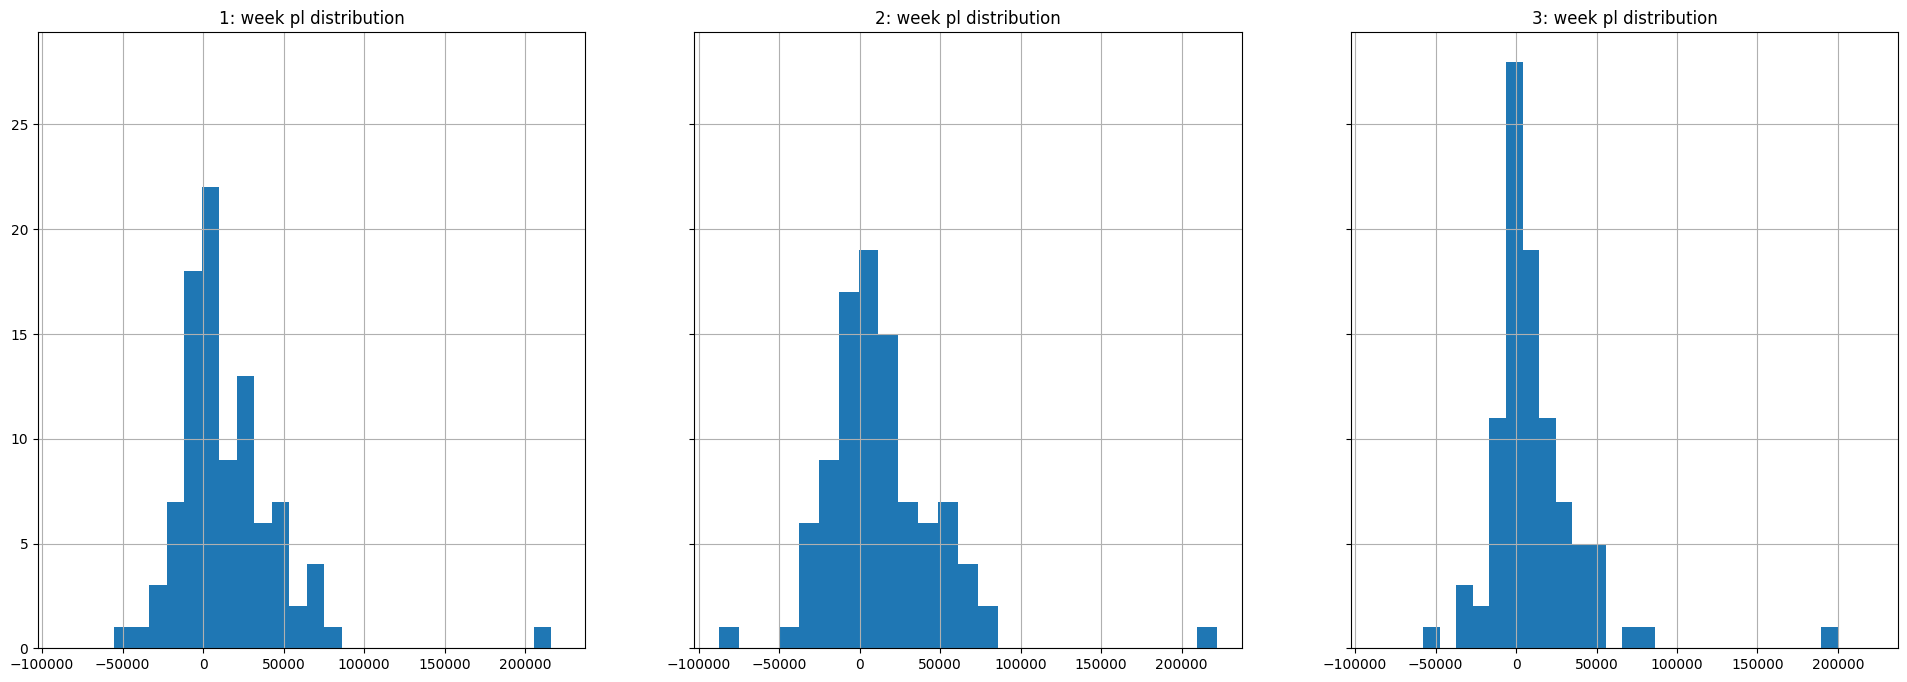

In [23]:
#@title 週ごとの運用用実績のプロット
#@markdown 1,2,3の戦略すべて､0付近の分布であり､大きなプラスがある週がいずれもある｡
#@markdown 2は分布が若干広い｡
#@markdown 3は0以下に分布が集中している

# 描画領域を定義
fig, axes = plt.subplots(1, len(results), figsize=(8 * len(results), 8), sharex=True, sharey=True)

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # 描画位置を指定
    ax = axes[i]
    # 分布をプロット
    results[k].week_pl.hist(bins=25, ax=ax)
    # タイトルを設定
    ax.set_title(f"{k}: week pl distribution")
#　描画
plt.show()

In [24]:
#@title 週ごとの運用実績の統計量
#@markdown 3は1,2と比べて平均が低い｡
#@markdown 2は最小値が一番小さく､最大値が一番高い｡

# week_plの分布の統計量

# 結合用データ保存
buff = []
# ストラテジー毎に処理
for k in results.keys():
    # week_plの統計量を取得します。
    df = results[k].loc[:, ["week_pl"]].describe().T
    # インデックスを編集してストラテジーのIDにする
    df.index = [k]
    # インデックス名変更
    df.index.name = "strategy_id"
    # 結合用に保存
    buff.append(df)
# 結合して表示
pd.concat(buff)

,count,mean,std,min,25%,50%,75%,max
strategy_id,,,,,,,,
1,95.0,14830.490526,33443.642090,-55109.0,-3783.0,6592.0,28517.50,216364.0
2,95.0,13218.402105,36345.440843,-87115.0,-7885.0,6471.0,27736.95,221841.0
3,95.0,10956.463158,29222.361487,-57775.0,-4114.0,4668.0,21467.50,200071.0


In [25]:
#@title 週毎の勝率、ペイオフレシオ、シャープレシオを算出
#@markdown 週毎の勝率が0.64以上であり､payoff_ratioも1がより大きく一回の勝ちが負けよりおおきいことが分かる｡

# 結合用データ保存
buff = []
# 戦略毎に処理
for k in results.keys():
    df_return = results[k]
    # 計算結果保存用
    d = {}
    # 件数
    d["count"] = df_return.shape[0]
    # 勝率
    d["win_ratio"] = (
        df_return.loc[df_return.loc[:, "week_return"] > 0].shape[0] / d["count"]
    )
    # ペイオフレシオ
    d["payoff_ratio"] = df_return.loc[
        df_return.loc[:, "week_return"] > 0, "week_return"
    ].mean() / (
        -1 * df_return.loc[df_return.loc[:, "week_return"] <= 0, "week_return"].mean()
    )
    # シャープレシオ
    d["sharp"] = (
        df_return.loc[:, "week_return"].mean() / df_return.loc[:, "week_return"].std()
    )
    # 平均PL
    d["avgPL"] = df_return.loc[:, "week_pl"].mean()
    # week_plの合計
    d["PL"] = df_return.loc[:, "week_pl"].sum()
    # strategy_idを設定
    df = pd.DataFrame([d], index=[k])
    # インデックス名を指定
    df.index.name = "strategy_id"
    # 結合用に保存
    buff.append(df)
# 結合して表示
pd.concat(buff)

,count,win_ratio,payoff_ratio,sharp,avgPL,PL
strategy_id,,,,,,
1,95,0.652632,2.401341,0.443447,14830.490526,1408896.6
2,95,0.642105,1.773224,0.363688,13218.402105,1255748.2
3,95,0.652632,2.129973,0.374934,10956.463158,1040864.0


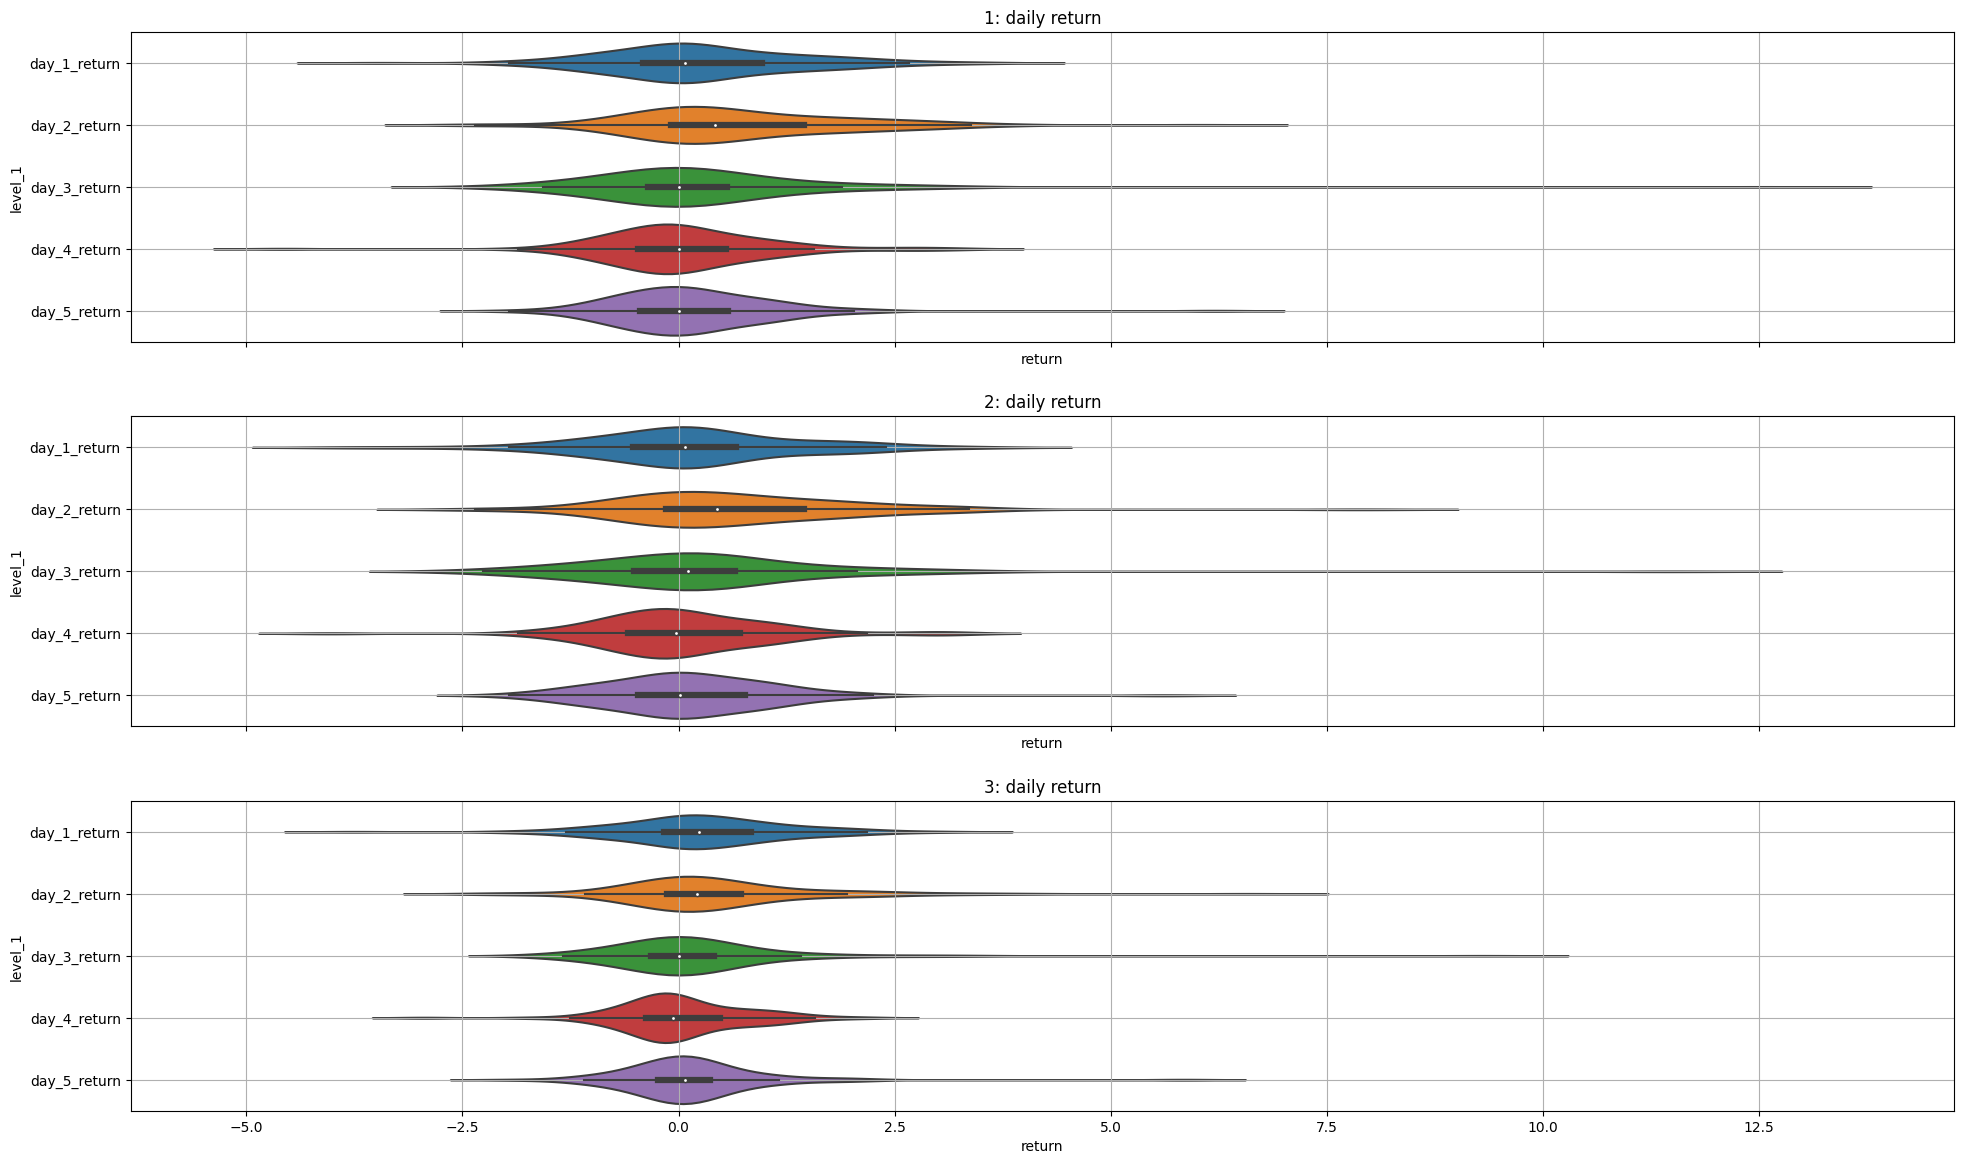

In [26]:
#@title 週毎に曜日別のリターンを分析するためのバイオリンプロット
#@markdown モデルごとに異なる傾向を示しているわけではなさそう｡
#@markdown 月や火は勝ちやすい傾向にあることが分かる｡
#@markdown また､水木金は0付近に集中しており､水や金は負けが小さく､勝ちが大きい傾向にある

# 描画領域を定義
fig, axes = plt.subplots(
    len(results), 1, figsize=(20, 4 * len(results)), sharex=True, sharey=True
)

# 描画用データ保存用
dfs_plot = {}

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # 描画位置を指定
    ax = axes[i]
    # 列を行に変換
    dfs_plot[k] = (
        results[k]
        .set_index("date")
        .loc[
            :,
            [
                "day_1_return",
                "day_2_return",
                "day_3_return",
                "day_4_return",
                "day_5_return",
            ],
        ]
        .stack()
        .to_frame()
        .reset_index()
        .rename(columns={0: "return"})
    )
    # 箱が見やすいように横方向を指定してプロット
    sns.violinplot(x="return", y="level_1", data=dfs_plot[k], ax=ax, orient="h")
    # タイトルを設定
    ax.set_title(f"{k}: daily return")
    # グリッドを表示
    ax.grid(True)
# 文字が重なって読みにくいので間隔調整
fig.tight_layout(pad=2.0)
# 描画
plt.show()

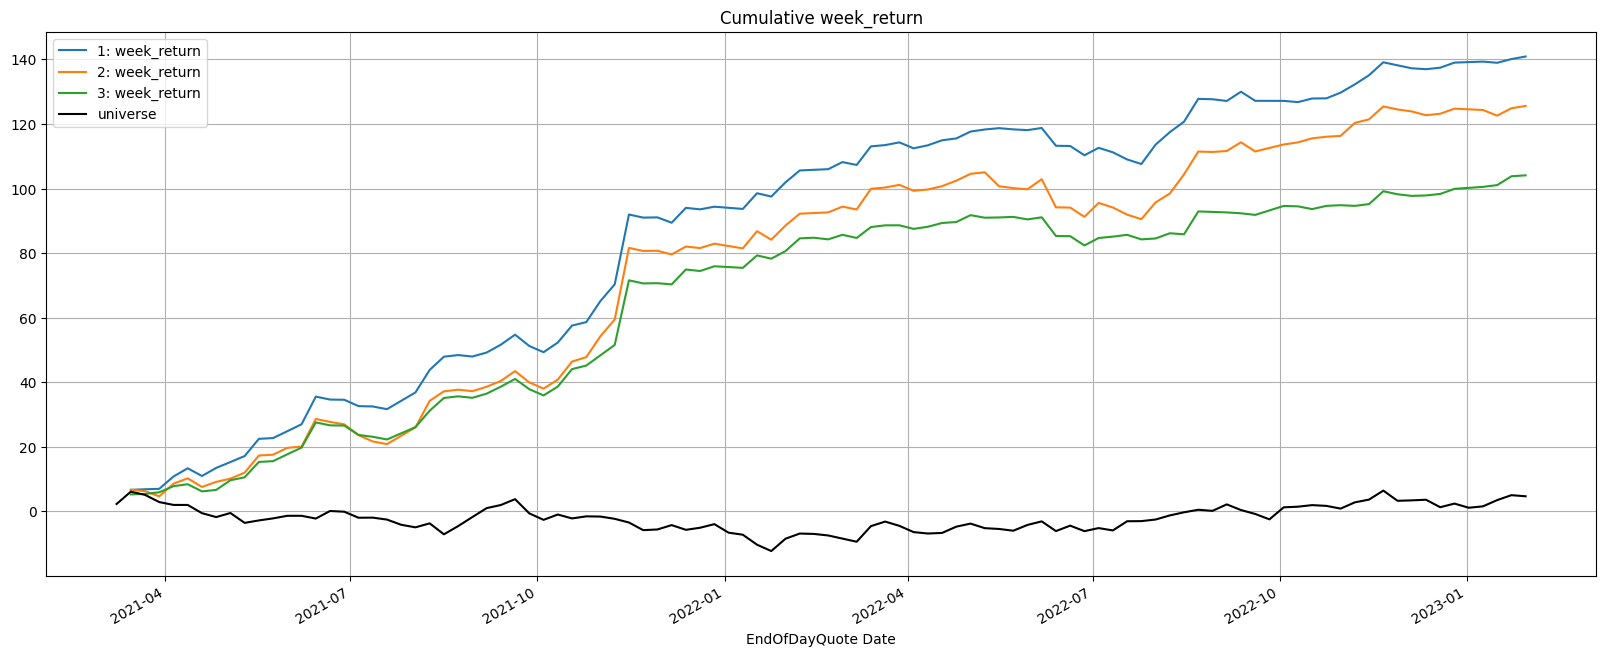

In [27]:
#@title 収益率の時系列を累積プロット
#@markdown 比較対象として取引対象(universe:2000銘柄)の全銘柄の平均週次リターンを計算｡
#@markdown 対比軸である取引対象の全銘柄の平均週次リターン｡1,2では収益率が2023年には100%付近とユニバースの平均大幅に上回っている


# 変数名を調整します。
# backtest_priceはユニバースで絞り込み済みです
df_price = backtest_price

# 週毎に始値と終値を取得
df_wp = (
    # start_dt以降の日付のみ計算
    df_price.loc[df_price.index >= start_dt].sort_values(["Local Code", "EndOfDayQuote Date"])
    # 銘柄コード毎に処理
    .groupby("Local Code")
    # 月曜日スタートで週にリサンプル
    .resample("W-MON", label="left", closed="left")
    # 始値は最初のレコード、終値は最後のレコードを取得
    .agg({"EndOfDayQuote Open": "first", "EndOfDayQuote ExchangeOfficialClose": "last"})
    # マルチインデックスを解除
    .reset_index(level=[0])
)
# Open が 0.0 の銘柄は値段が付かなかった銘柄で、バックテストでは購入対象外であるため除外する
df_wp = df_wp.loc[df_wp.loc[:, "EndOfDayQuote Open"] != 0.0]
# 銘柄毎の週次リターンを計算
df_wp.loc[:, "universe"] = (
    (
        (
            df_wp.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
            / df_wp.loc[:, "EndOfDayQuote Open"]
        )
        - 1
    )
    * 100
)
# ユニバースの週毎のリターンを計算します。
df_universe_return = df_wp.groupby(df_wp.index)["universe"].mean().to_frame()

# 描画領域を定義
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)

# 戦略毎に処理
for k in results.keys():
    # 描画位置を指定
    ax = axes
    # 戦略別の累積リターンを描画
    results[k].set_index("date").loc[:, ["week_return"]].rename(
        columns={"week_return": f"{k}: week_return"}
    ).cumsum().plot(ax=ax)

# ユニバースの週次リターンの累積をプロット
df_universe_return.cumsum().plot(ax=ax, color="black", label="universe")

# 表示を調整
ax.set_title("Cumulative week_return")
# グリッドを表示
ax.grid(True)
# 描画
plt.show()

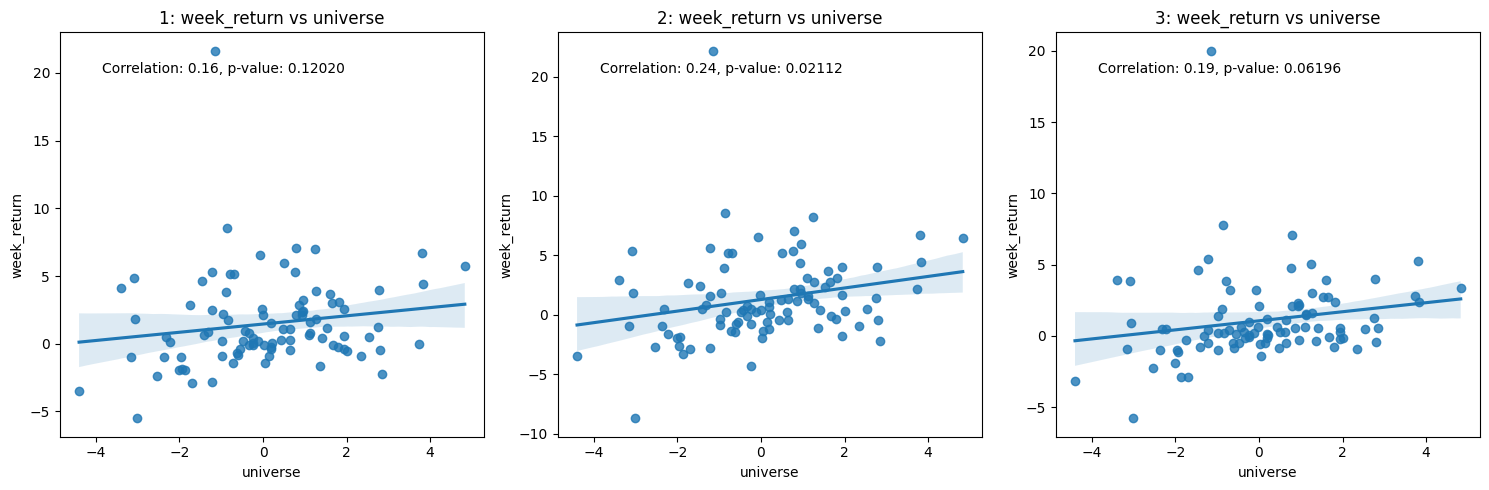

In [28]:
#@title ユニバースとリターンの散布図をプロット
#@markdown マーケットの動きに対してポートフォリオの運用実績がどのように分布するかを確認するために利用｡
#@markdown 各戦略とユニバースのリターンが相関が低く､ユニバースの影響をあまり受けないことが分かる｡
#@markdown 一方､week_returnが20付近の点が相関を低くしている可能性がある点には注意が必要


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # df_universe_returnとresults[k]で日付が一致する部分のみを取り出す
    common_dates = df_universe_return.index.intersection(results[k]['date'])
    common_df_universe = df_universe_return.loc[common_dates]
    common_results = results[k].set_index('date').loc[common_dates]

    # 散布図をプロット
    sns.regplot(
        x=common_df_universe.iloc[:,0], 
        y=common_results["week_return"],
        ax=axs[i]
    )
    
    # 相関係数とp値を計算
    corr, p_value = stats.pearsonr(common_df_universe.iloc[:,0],common_results["week_return"])
    
    # 相関係数とp値をプロットにテキストとして追加
    axs[i].text(0.1, 0.9, f'Correlation: {corr:.2f}, p-value: {p_value:.5f}', transform=axs[i].transAxes)
    
    # タイトルを設定
    axs[i].set_title(f"{k}: week_return vs universe")

plt.tight_layout()
plt.show()

In [29]:
#@title ベータ値の算出
#@markdown 戦略1はユニバースが10%変動すると6.8%程度の変動が発生する取引戦略である｡
# 結合用に保存
buff = []

# 戦略毎に処理
for k in results.keys():
    # df_universe_returnとresults[k]で日付が一致する部分のみを取り出す
    common_dates = df_universe_return.index.intersection(results[k]['date'])
    common_df_universe = df_universe_return.loc[common_dates]
    common_results = results[k].set_index('date').loc[common_dates]

    # ベータを計算
    res = stats.linregress(common_df_universe.iloc[:,0], common_results["week_return"])

    # 一覧表示用にデータフレームを作成
    df_beta = pd.DataFrame([res.slope], index=[k], columns=["beta"])

    # インデックス名を設定
    df_beta.index.name = "storategy_id"

    # 保存
    buff.append(df_beta)

# 結合して表示
pd.concat(buff)


,beta
storategy_id,
1,0.303524
2,0.485684
3,0.317658


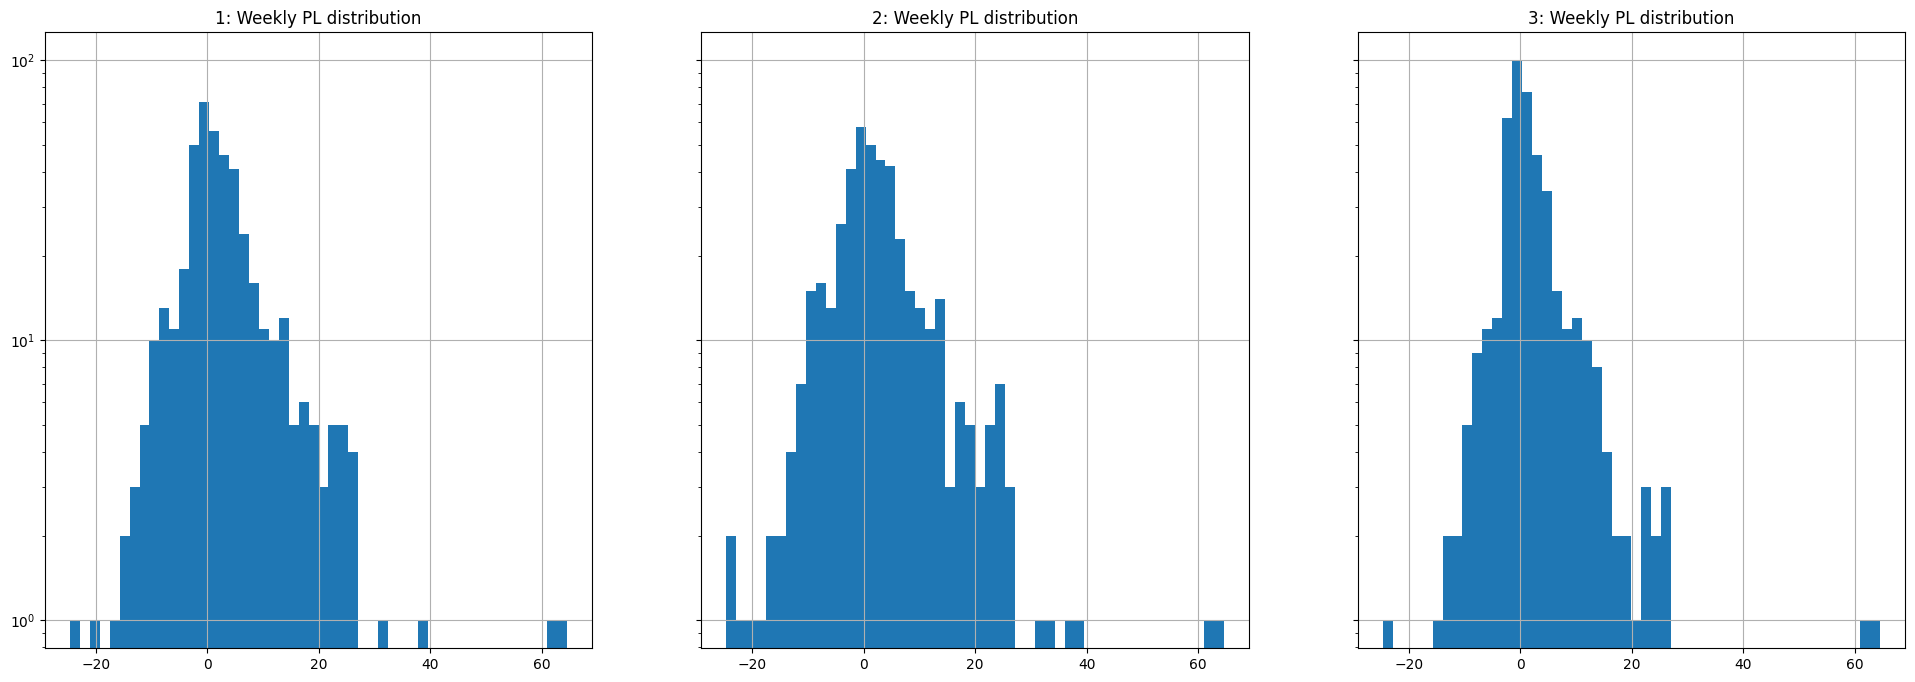

In [30]:
#@title 銘柄毎のリターンの分布をヒストグラムでプロット
#@markdown 銘柄毎のリターンの分布をヒストグラムでプロット｡リターンを大きな勝ちに依存している戦略であることが分かる

# 各銘柄毎の分析

# 分析用データ保存用
dfs_analyze = {}
# 戦略毎に処理
for i in stocks.keys():
    # 分析用にデータをコピー
    df_analyze = stocks[i].copy()
    # day5に必ず値が存在するように調整します
    df_analyze.loc[:, ["day_1", "day_2", "day_3", "day_4", "day_5"]] = (
        df_analyze.loc[:, ["day_1", "day_2", "day_3", "day_4", "day_5"]]
        .replace(0.0, np.nan)
        .ffill(axis=1)
    )
    # 終値とエントリーの差分を計算
    df_analyze.loc[:, "diff"] = df_analyze.loc[:, ["entry", "day_5"]].diff(axis=1)[
        "day_5"
    ]
    # 損益を計算します
    df_analyze.loc[:, "pl"] = df_analyze.loc[:, "diff"] * df_analyze.loc[:, "actual"]
    # リターンを計算します
    df_analyze.loc[:, "return"] = (
        (df_analyze.loc[:, "day_5"] / df_analyze.loc[:, "entry"]) - 1
    ) * 100
    # infを0.0に変換
    df_analyze = df_analyze.replace(np.inf, 0.0)
    # 処理結果を保存
    dfs_analyze[i] = df_analyze

    # dfs_analyze[1].head(2)

# 描画領域を定義
fig, axes = plt.subplots(1, len(dfs_analyze), figsize=(8 * len(dfs_analyze), 8), sharex=True, sharey=True)

# 戦略毎に処理
for i, k in enumerate(dfs_analyze.keys()):
    # 描画位置を指定
    ax = axes[i]
    # ヒストグラムをプロット
    dfs_analyze[k].groupby(["date", "Local Code"])["return"].sum().hist(bins=50, log=True, ax=ax)
    # タイトルを設定
    ax.set_title(f"{k}: Weekly PL distribution")
# 描画
plt.show()

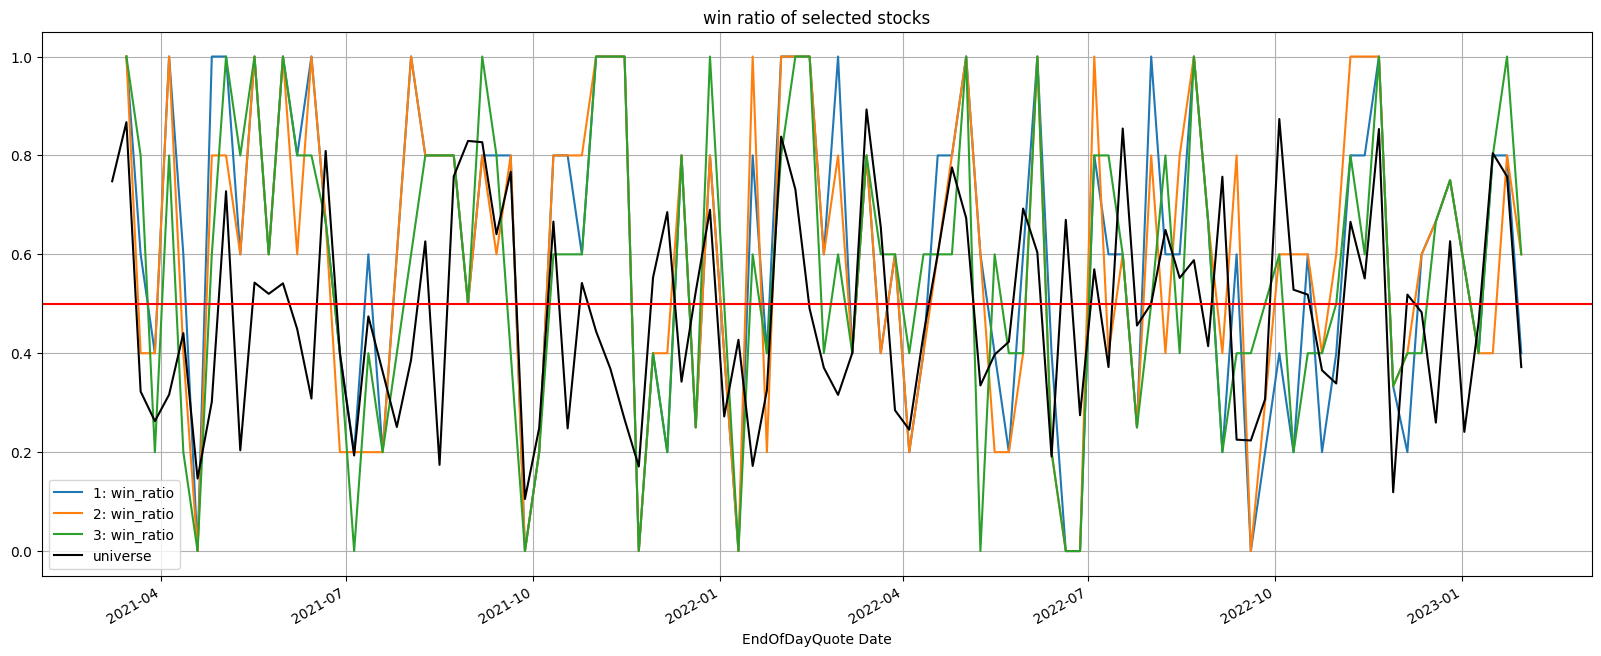

,count,mean,std,min,25%,50%,75%,max
1: win_ratio,95.0,0.605088,0.309418,0.0,0.4,0.6,0.8,1.0
2: win_ratio,95.0,0.596667,0.310814,0.0,0.4,0.6,0.8,1.0
3: win_ratio,95.0,0.571404,0.299366,0.0,0.4,0.6,0.8,1.0


In [31]:
#@title 週毎の銘柄の勝率
#@markdown 黒線のuniverseに対してどの時期に銘柄単位で勝率が低く、どの時期に勝率が高かったを確認｡戦略3は勝率が0の箇所が非常に多い｡
# 描画領域を定義
fig, ax = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)

# 統計量表示用
buff = []
# 戦略毎に処理
for k in dfs_analyze.keys():
    # 週毎の勝ち銘柄率を計算
    win_ratio = (
        dfs_analyze[k]
        .set_index("date")
        .groupby("date")
        .apply(lambda x: (x.pl > 0).sum() / x.shape[0])
        .to_frame()
        .rename(columns={0: f"{k}: win_ratio"})
    )
    # プロット
    win_ratio.plot(ax=ax)
    # 統計量を保存
    buff.append(win_ratio.describe().T)
# ユニバースの勝ち銘柄率をプロット
df_wp.groupby(df_wp.index).apply(lambda x: (x.universe > 0).sum() / x.shape[0]).rename(
    "universe"
).to_frame().plot(ax=ax, color="black")
# タイトルを設定
ax.set_title("win ratio of selected stocks")
# グリッド表示
ax.grid(True)
# 0.5に基準線を描画
ax.axhline(y=0.5, color="red")
#  描画
plt.show()
# 週毎の勝ち銘柄率の統計量
display(pd.concat(buff))